In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

import numpy as np
from scipy.cluster.vq import kmeans, vq
from scipy.optimize import minimize
from sklearn.linear_model import Lasso, Ridge
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist
from skimage.restoration import denoise_nl_means, estimate_sigma

In [2]:
import jax.numpy as jnp
import cr.sparse as crs
from cr.sparse import lop
from cr.sparse.cvx.adm import yall1
import spgl1

K means clustering on tiles taken from an image

(256, 256)


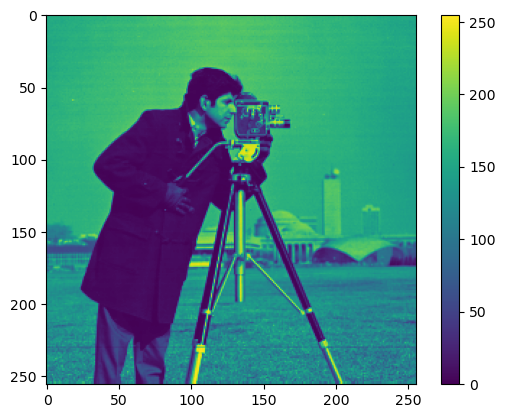

In [3]:
image_number = 3
# dimensionality (N) of subspace = 64
tile_w = 8
 
image = cv2.imread(f"Dataset/Image{image_number}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
mindim = np.min(image.shape)
image = image[:mindim, :mindim]

plt.imshow(image)
plt.colorbar()
plt.show();

In [4]:
def return_tiles(image, tile_width):
    """
    image: A 2D array
    tile_width: the width of a square tile
    """
    width, height = image.shape

    # Calculate the number of tiles in each dimension
    num_tiles_x = width // tile_width
    num_tiles_y = height // tile_width

    # Initialize an empty array to store tiles
    # Reshape the image into tiles
    tiles = image[:num_tiles_y * tile_width, :num_tiles_x * tile_width].reshape(
        num_tiles_y, tile_width, num_tiles_x, tile_width)

    # Transpose the axes to get the desired shape
    tiles2d = tiles.transpose(0, 2, 1, 3).reshape(num_tiles_y, num_tiles_x, tile_width, tile_width)
    tiles1d = tiles2d.reshape(num_tiles_y*num_tiles_x, tile_width*tile_width)

    return tiles2d, tiles1d

In [5]:
# The data vector
im_tiles2d, im_tiles1d = return_tiles(image, tile_w)
print(im_tiles2d.shape)
print(im_tiles1d.shape)

(32, 32, 8, 8)
(1024, 64)


In [6]:
def visualize_tiles(tiles_array):
    num_tiles_y, num_tiles_x, tile_width, _ = tiles_array.shape

    #subplot with a grid of tiles
    fig, axes = plt.subplots(num_tiles_y, num_tiles_x, figsize=(10, 10))

    # Iterate through each tile and display
    for i in range(num_tiles_y):
        for j in range(num_tiles_x):
            axes[i, j].imshow(tiles_array[i, j, :, :])
            axes[i, j].axis('off')  # Turn off axis labels

    plt.show()

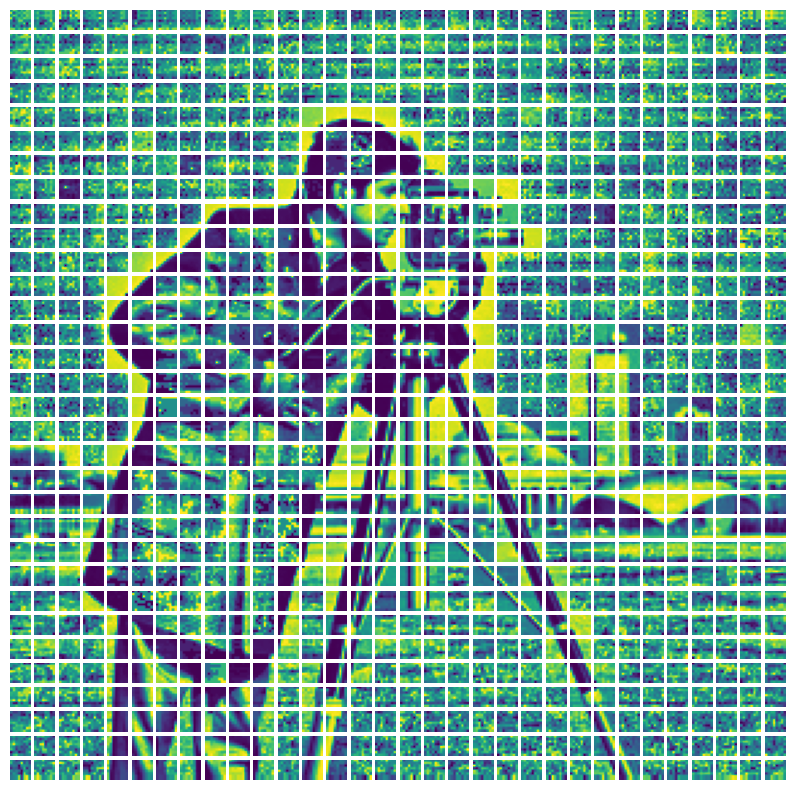

In [7]:
visualize_tiles(im_tiles2d)

In [8]:
im_tiles1d = im_tiles1d.astype(float)

### Decide the number of clusters
* And if needed, change the num_clusters argument in the start 

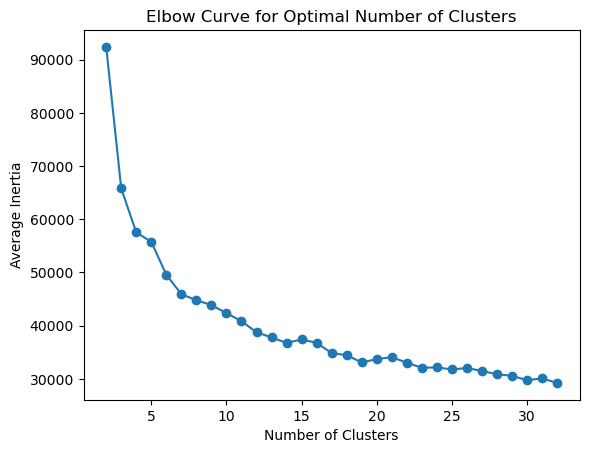

[92405.85879727956,
 65791.49707602269,
 57543.50933139105,
 55759.352728558675,
 49571.8831050633,
 45919.52552028601,
 44781.851022894756,
 43875.19824329491,
 42370.52081267424,
 40835.457343109716,
 38762.20149989579,
 37779.216695865114,
 36771.29943554458,
 37411.49815007404,
 36769.98556317441,
 34849.0471761709,
 34439.10588076462,
 33091.57649880916,
 33705.78378092533,
 34085.41455505087,
 33026.914219450104,
 32088.79638523917,
 32152.821539745786,
 31769.722553370262,
 32033.968570985344,
 31486.46803368213,
 30867.81142421272,
 30570.57083298367,
 29749.50048520846,
 30082.507518685277,
 29235.236559084115]

In [9]:
def calculate_inertia(data, centroids, cluster_indices):
    # Calculate within-cluster sum of squared distances
    # print(type(cluster_indices), cluster_indices.shape)
    distances = np.sum((data - centroids[cluster_indices]) ** 2)
    inertia = distances / len(data)
    return inertia

def elbow_method(data, max_clusters=32):
    inertias = []

    for num_clusters in range(2, max_clusters + 1):
        centroids, distortion = kmeans(data, num_clusters)
        cluster_indices, _ = vq(data, centroids)
        inertia = calculate_inertia(data, centroids, cluster_indices)
        inertias.append(inertia)

    plt.plot(range(2, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Curve for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Inertia')
    plt.show()

    return inertias

elbow_method(im_tiles1d, 32)

In [10]:
num_clusters = 20 

In [11]:
# Perform Clustering

def getKmeans(data, num_clusters):
    # Adjust the number of clusters as needed
    centroids, _ = kmeans(data, num_clusters)
    print('data dimensions:', data.shape)
    print('number of clusters:', num_clusters)
    print('centroids shape:', centroids.shape)

    #vector quatization
    cluster_indices, _ = vq(data, centroids)
    print('cluster_indices shape:', cluster_indices.shape)
    return cluster_indices

cluster_indices = getKmeans(im_tiles1d, num_clusters)

data dimensions: (1024, 64)
number of clusters: 20
centroids shape: (20, 64)
cluster_indices shape: (1024,)


In [12]:
def getRobustSSCV1(Y, lmbda):
    """
    Robust Subspace Clustering: Candes, Sankoltanobi
    no affine constraint
    has beta_i = 0 constraint
    """
    # Step 1: Compute sparse coefficients
    N, n = Y.shape
    
    B = np.zeros((N, N))
    for i in range(N):
        print('%.d th cluster done'%(i))
        y_i = Y[i, :]

        # Define the objective function and constraints
        def objective_function(beta):
            return np.linalg.norm(y_i - np.dot(beta, Y))**2 + lmbda * np.linalg.norm(beta, ord=1)

        # Define the equality constraint beta_i = 0
        def equality_constraint(beta):
            return beta[i]

        # Solve the optimization problem
        initial_guess = np.zeros(N)
        bounds = [(None, None) for _ in range(N)]  # No bounds for beta
        constraints = {'type': 'eq', 'fun': equality_constraint}
        res = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        beta_i = res.x
        
        B[i, :] = np.abs(beta_i)
    
    # Step 2: Construct similarity graph
    W = np.abs(B) + np.abs(B.T)
    
    # Step 3: Compute degree matrix
    D = np.diag(np.sum(W, axis=1))
    
    # Step 4: Compute normalized Laplacian
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    L_norm = D_sqrt_inv @ (D - W) @ D_sqrt_inv
    
    # Step 5: Spectral clustering
    spectral_clustering = SpectralClustering(n_clusters='auto', affinity='precomputed', random_state=0)
    labels = spectral_clustering.fit_predict(L_norm)
   
    return labels

# robust_cluster_indices = getRobustSSCV1(im_tiles1d, lmbda=0.5)
# print('robust_cluster_indices shape:', robust_cluster_indices.shape)

In [6]:
def getRobustSSCV2(Y, lmbda):
    """
    Robust Subspace Clustering: Candes, Sankoltanobi
    has affine constraint
    no beta_i = 0 constraint
    """
    # Step 1: Compute sparse coefficients
    N, n = Y.shape
    
    B = np.zeros((N, N))
    for i in range(N):
        print('%.d th cluster done'%(i))
        y_i = Y[i, :]

        # Define the objective function and constraints
        def objective_function(beta):
            return np.linalg.norm(y_i - np.dot(beta, Y))**2 + lmbda * np.linalg.norm(beta, ord=1)

        # Define the affine constraint sum(beta_i) = 1
        def equality_constraint(beta):
            return np.sum(beta) - 1

        # Solve the optimization problem
        initial_guess = np.zeros(N)
        bounds = [(None, None) for _ in range(N)]  # No bounds for beta
        constraints = {'type': 'eq', 'fun': equality_constraint}
        res = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        beta_i = res.x
        
        B[i, :] = np.abs(beta_i)
    
    # Step 2: Construct similarity graph
    W = np.abs(B) + np.abs(B.T)
    
    # Step 3: Compute degree matrix
    D = np.diag(np.sum(W, axis=1))
    
    # Step 4: Compute normalized Laplacian
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    L_norm = D_sqrt_inv @ (D - W) @ D_sqrt_inv
    
    # Step 5: Spectral clustering
    spectral_clustering = SpectralClustering(n_clusters='auto', affinity='precomputed', random_state=0)
    labels = spectral_clustering.fit_predict(L_norm)
   
    return labels

robust_cluster_indices = getRobustSSCV2(im_tiles1d, lmbda=0.5)
print('robust_cluster_indices shape:', robust_cluster_indices.shape)

ith cluster done


In [39]:
def getRobustSSCV3(Y, lmbda):
    """
    Robust Subspace Clustering: Candes, Sankoltanobi
    no affine constraint, no beta_i=0 constraint
    """
    # Step 1: Compute sparse coefficients
    N, n = Y.shape
    
    B = np.zeros((N, N))

    # Iterative solution: Error when some L_norms are fitted
    # for i in range(N):
    #     y_i = Y[i, :]

    #     # Define the objective function
    #     # Fit Lasso regression
    #     lasso = Lasso(alpha=lmbda, fit_intercept=False)
    #     lasso.fit(Y.T, y_i.T)
    #     beta_i = lasso.coef_
        
    #     B[i, :] = beta_i

    #Vectorized- Ridge and LASSO
    ridge = Ridge(alpha=lmbda, fit_intercept=False)
    ridge.fit(Y.T, Y.T)
    B = ridge.coef_
    print(B.shape)
    print(B[:10,:10])

    # Step 2: Construct similarity graph
    W = np.abs(B) + np.abs(B.T)
    
    # Step 3: Compute degree matrix
    D = np.diag(np.sum(W, axis=1))
    
    # Step 4: Compute normalized Laplacian
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    L_norm = D_sqrt_inv @ (D - W) @ D_sqrt_inv
    
    # Step 5: Spectral clustering
    spectral_clustering = SpectralClustering(n_clusters=20, affinity='precomputed', random_state=0)
    labels = spectral_clustering.fit_predict(L_norm)
   
    return labels

robust_cluster_indices = getRobustSSCV3(im_tiles1d, lmbda=0.5)
print('robust_cluster_indices shape:', robust_cluster_indices.shape)

(3600, 3600)
[[ 1.23767290e-02  2.34758099e-03  2.15244252e-03  9.60434799e-04
   6.65103942e-05  7.29755624e-04 -6.75722416e-05  7.46202238e-04
  -1.38447400e-03 -2.21191867e-03]
 [ 2.34758099e-03  1.38700408e-02  2.19759300e-03 -5.44414410e-04
   3.21676214e-04  4.93225665e-04  8.42524410e-04 -5.82606750e-04
  -1.53632396e-03 -1.15297761e-03]
 [ 2.15244252e-03  2.19759300e-03  1.79941388e-02 -3.85179510e-04
   1.88794913e-04  2.79931394e-04 -4.26068366e-04 -1.34861386e-04
  -6.26814490e-04 -1.89781197e-03]
 [ 9.60434799e-04 -5.44414410e-04 -3.85179510e-04  7.37764335e-03
  -1.10096563e-03 -2.17545638e-04  4.31437992e-05 -7.60462386e-04
  -3.21329809e-04 -5.60097037e-04]
 [ 6.65103942e-05  3.21676214e-04  1.88794913e-04 -1.10096563e-03
   4.21924226e-03  7.33390280e-04  3.93301251e-04  8.66469212e-04
   1.01545912e-03  1.88122225e-03]
 [ 7.29755624e-04  4.93225665e-04  2.79931394e-04 -2.17545638e-04
   7.33390280e-04  2.89477619e-03  7.65728648e-04  1.03111300e-03
   7.72813154e-04  1

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\scipy\sparse\csgraph\_laplacian.py:546: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(isolated_node_mask, 1, np.sqrt(w))


ValueError: array must not contain infs or NaNs

I had another version of RobustSSCV4 earlier without an affine constraint, but just trying to see if I can get a better clustering by indirectly having the $\beta_i = 0$ subspace constraint (By removing the vectors in to have a search in the )

In [11]:
def getRobustSSCV4(Y, lmbda):
    """
    Robust Subspace Clustering: Candes, Sankoltanobi
    with/without affine constraint
    has beta_i = 0 constraint in a second way
    """
    # Step 1: Compute sparse coefficients
    N, n = Y.shape
    #3600,64

    B = np.zeros((N, N))
    for i in range(N):
        print('%.d th cluster start'%(i))
        y_i = Y[i, :]
        
        # Remove the i-th row from Y
        y_others = np.delete(Y, i, axis=0)
        # print(y_others.shape) #3599,64

        # Define the objective function
        def objective_function(beta):
            # Without inserting a zero at the i-th position of the resulting coefficient vector
            return np.linalg.norm(y_i - np.dot(beta, y_others))**2 + lmbda * np.linalg.norm(beta, ord=1)
        
        # Define the affine constraint sum(beta_i) = 1
        def equality_constraint(beta):
            return np.sum(beta) - 1

        # Solve the optimization problem
        initial_guess = np.zeros(N - 1)
        bounds = [(None, None) for _ in range(N - 1)]  # No bounds for beta
        constraints = {'type': 'eq', 'fun': equality_constraint}
        res = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        beta_i = np.insert(res.x, i, 0)  # Insert zero at the i-th position
        
        B[i, :] = np.abs(beta_i)
    
    # Step 2: Construct similarity graph
    W = np.abs(B) + np.abs(B.T)
    
    # Step 3: Compute degree matrix
    D = np.diag(np.sum(W, axis=1))
    
    # Step 4: Compute normalized Laplacian
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    L_norm = D_sqrt_inv @ (D - W) @ D_sqrt_inv
    
    # Step 5: Spectral clustering
    spectral_clustering = SpectralClustering(n_clusters='auto', affinity='precomputed', random_state=0)
    labels = spectral_clustering.fit_predict(L_norm)
   
    return labels

robust_cluster_indices = getRobustSSCV4(im_tiles1d, lmbda=0.5)
print('robust_cluster_indices shape:', robust_cluster_indices.shape)

0 th cluster done
(3599, 64)
1 th cluster done
(3599, 64)


KeyboardInterrupt: 

In [10]:
def getRobustSSCV5(Y, sigma):
    """
    Robust Subspace Clustering: Candes, Sankoltanobi
    Other solvers--> cr sparse
    without affine constraint
    has beta_i = 0 constraint in a second way
    https://carnotresearch.github.io/cr-sparse-companion/modules/l1/yall1/examples/basis_pursuit-denoising.html
    """
    # Step 1: Compute sparse coefficients
    N, n = Y.shape
    #3600,64


    B = np.zeros((N, N))
    for i in range(N):
        
        y_i = Y[i, :]
        
        # Remove the i-th row from Y
        y_others = np.delete(Y, i, axis=0)
        # print(y_others.shape) # (N-1,n) = 3599,64

        A = y_others.T # (n,N-1)
        T = lop.real_matrix(A)
        T = lop.jit(T)
        
        b = jnp.asarray(y_i.T) #(n,1)
        sol = yall1.solve(T, b, rho=sigma)

        # print(type(sol.x)) --> <class 'jaxlib.xla_extension.ArrayImpl'>
              
        result = np.array(sol.x).T
        # print(result.shape) # (3599,)

        if i%10 == 0:
            print('%.d th cluster result:'%(i))
            print('L1 norm b', np.linalg.norm(b, 1))
            print('L1 norm x', np.linalg.norm(result, 1))
            print('L2 norm Ax-b', np.linalg.norm(A@result - b, 2))
        # CHECK THE COLUMN MAGNITUDES TO CHECK IF --> DO WE NEED TO MAKE UNIT NORM?
        # CHECK THE MISMATCH GETWEEN Ax and b, check |Ax-b|

        beta_i = np.insert(result, i, 0)  # Insert zero at the i-th position
        # print(beta_i.shape) # (3600,)

        B[i, :] = np.abs(beta_i)
    
    # Checking beta value range--> very Large :(
    print("checking rough beta range:",B[1])

    # Step 2: Construct similarity graph
    W = np.abs(B) + np.abs(B.T)
    
    # Step 3: Compute degree matrix
    D = np.diag(np.sum(W, axis=1))
    
    # Step 4: Compute normalized Laplacian
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    L_norm = D_sqrt_inv @ (D - W) @ D_sqrt_inv
    
    # Step 5: Compute the eigenvalues
    eigenvalues, _ = np.linalg.eigh(L_norm)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    differences = np.diff(sorted_eigenvalues)
    i_max = np.argmax(differences)
    N = len(sorted_eigenvalues)
    L_hat = N - (i_max + 1)

    # Step 6: Spectral clustering
    spectral_clustering = SpectralClustering(n_clusters=L_hat, affinity='precomputed', random_state=0)
    labels = spectral_clustering.fit_predict(L_norm)
   
    return labels

robust_cluster_indices = getRobustSSCV5(im_tiles1d, sigma=50)
print('robust_cluster_indices shape:', robust_cluster_indices.shape)

0 th cluster result:
L1 norm b 6572.0
L1 norm x 7.3419824e+27
L2 norm Ax-b inf
10 th cluster result:
L1 norm b 7509.0
L1 norm x 9.1011035e+27
L2 norm Ax-b inf
20 th cluster result:
L1 norm b 4679.0
L1 norm x 4.0681413e+27
L2 norm Ax-b inf
30 th cluster result:
L1 norm b 6268.0
L1 norm x 6.780503e+27
L2 norm Ax-b inf
40 th cluster result:
L1 norm b 11743.0
L1 norm x 1.7833779e+28
L2 norm Ax-b inf
50 th cluster result:
L1 norm b 4760.0
L1 norm x 4.198547e+27
L2 norm Ax-b inf
60 th cluster result:
L1 norm b 4441.0
L1 norm x 3.7020803e+27
L2 norm Ax-b inf
70 th cluster result:
L1 norm b 7317.0
L1 norm x 8.732098e+27
L2 norm Ax-b inf
80 th cluster result:
L1 norm b 6329.0
L1 norm x 6.868742e+27
L2 norm Ax-b inf
90 th cluster result:
L1 norm b 7924.0
L1 norm x 9.907652e+27
L2 norm Ax-b inf
100 th cluster result:
L1 norm b 8374.0
L1 norm x 1.0790795e+28
L2 norm Ax-b inf
110 th cluster result:
L1 norm b 7253.0
L1 norm x 8.6049073e+27
L2 norm Ax-b inf
120 th cluster result:
L1 norm b 3409.0
L1 

KeyboardInterrupt: 

In [71]:
# def getRobustSSCV6(Y, sigma):
"""
Robust Subspace Clustering: Candes, Sankoltanobi
Other solvers--> spgl1
without affine constraint
has beta_i = 0 constraint in a second way
https://spgl1.readthedocs.io/en/latest/api/generated/spgl1.spgl1.html
https://spgl1.readthedocs.io/en/latest/tutorials/spgl1.html#sphx-glr-tutorials-spgl1-py
"""
# Step 1: Compute sparse coefficients
Y = im_tiles1d
N, n = Y.shape
#3600,64


B = np.zeros((N, N))
for i in range(N):
    
    y_i = Y[i, :]
    
    # Remove the i-th row from Y
    y_others = np.delete(Y, i, axis=0)
    # print(y_others.shape) # (N-1,n) = 3599,64

    A = y_others.T # (n,N-1)
    b = y_i.T #(n,1)
    tau = 1
    # sigma = 100 #fixed sigma
    sigma = 0.05 * np.linalg.norm(b, 2)
    sol_x, resid, grad, info = spgl1.spg_bpdn(A, b,sigma, verbosity=1)

    # print(type(sol_x)) --> <class 'numpy.ndarray'>
            
    result = np.array(sol_x).T
    # print(result.shape) # (3599,)

    if i%10 == 0:
        print('%.d th tile result:'%(i))
        print('L1 norm b', np.linalg.norm(b, 1))
        print('Sigma', sigma)
        print('L1 norm x', np.linalg.norm(result, 1))
        print('L2 norm Ax-b', np.linalg.norm(A@result - b, 2))
    # CHECK THE COLUMN MAGNITUDES TO CHECK IF --> DO WE NEED TO MAKE UNIT NORM?
    # CHECK THE MISMATCH GETWEEN Ax and b, check |Ax-b|

    beta_i = np.insert(result, i, 0)  # Insert zero at the i-th position
    # print(beta_i.shape) # (3600,)

    B[i, :] = np.abs(beta_i)
    
# Checking beta value range--> very Large :(
print("checking rough beta range:",B[1])

# Step 2: Construct similarity graph
W = np.abs(B) + np.abs(B.T)

# Step 3: Compute degree matrix
D = np.diag(np.sum(W, axis=1))

# Step 4: Compute normalized Laplacian
D_sqrt_inv = np.linalg.inv(np.sqrt(D))
L_norm = D_sqrt_inv @ (D - W) @ D_sqrt_inv

# Step 5: Compute the eigenvalues
eigenvalues, _ = np.linalg.eigh(L_norm)
sorted_eigenvalues = np.sort(eigenvalues)[::-1]
differences = np.diff(sorted_eigenvalues)
i_max = np.argmax(differences)
N = len(sorted_eigenvalues)
L_hat = N - (i_max + 1)

# To get the similarity matrix from the normalized Laplacian, we can use: S = I - L
S = np.eye(L_norm.shape[0]) - L_norm

# Step 6: Spectral clustering
spectral_clustering = SpectralClustering(n_clusters=L_hat, affinity='precomputed', random_state=0)
labels = spectral_clustering.fit_predict(W)
   
#     return labels

# robust_cluster_indices = getRobustSSCV6(im_tiles1d, sigma=50)
# print('robust_cluster_indices shape:', robust_cluster_indices.shape)


SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.25e+03

Optimality tol        : 1.00e-04     
Target objective      : 6.23e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


EXIT -- Found a root

Products with A     :      99        Total time   (secs) :     0.0
Products with A^H   :      72        Project time (secs) :     0.0
Newton iterations   :      22        Mat-vec time (secs) :     0.0
Line search its     :      27        Subspace iterations :       0
0 th tile result:
L1 norm b 9968.0
Sigma 62.306059095404194
L1 norm x 0.7874859437320342
L2 norm Ax-b 62.30037246309098

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.25e+03

Optimality tol        : 1.00e-04     
Target objective      : 6.27e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


Linesearch failed with error 1. Damping max BB scaling to 10000.0



EXIT -- Found a root

Products with A     :    1094        Total time   (secs) :     0.4
Products with A^H   :     696        Project time (secs) :     0.2
Newton iterations   :     229        Mat-vec time (secs) :     0.1
Line search its     :     398        Subspace iterations :       0
140 th tile result:
L1 norm b 11800.0
Sigma 73.99621611947465
L1 norm x 0.9982431442330613
L2 norm Ax-b 73.98984526266294

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.26e+03

Optimality tol        : 1.00e-04     
Target objective      : 6.32e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1608        Total time   (secs) :     0.5
Products with A^H   :     798        Project time (secs) :     0.2
Newton iterations   :     206        Mat-vec time (secs) :     0.0
Line search its     :     788        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.25e+03

Optimality tol        : 1.00e-04     
Target objective      : 6.27e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1352        Total time   (secs) :     0.5
Products with A^H   :     791        Project time (secs) :     0.2
Newton iterations   :     178        Mat-vec time (secs) :     0.0
Line search its     :     559        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1540        Total time   (secs) :     0.3
Products with A^H   :     629        Project time (secs) :     0.0
Newton iterations   :     123        Mat-vec time (secs) :     0.0
Line search its     :     889        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 4.29e+01

Optimality tol        : 1.00e-04     
Target objective      : 2.14e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1128        Total time   (secs) :     0.3
Products with A^H   :     432        Project time (secs) :     0.1
Newton iterations   :      56        Mat-vec time (secs) :     0.0
Line search its     :     671        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 4.08e+02

Optimality tol        : 1.00e-04     
Target objective      : 2.04e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1331        Total time   (secs) :     0.3
Products with A^H   :     686        Project time (secs) :     0.1
Newton iterations   :      96        Mat-vec time (secs) :     0.1
Line search its     :     645        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1046        Total time   (secs) :     0.3
Products with A^H   :     451        Project time (secs) :     0.1
Newton iterations   :      56        Mat-vec time (secs) :     0.0
Line search its     :     573        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.18e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.89e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1333        Total time   (secs) :     0.5
Products with A^H   :     830        Project time (secs) :     0.2
Newton iterations   :     211        Mat-vec time (secs) :     0.0
Line search its     :     502        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1359        Total time   (secs) :     0.3
Products with A^H   :     526        Project time (secs) :     0.2
Newton iterations   :      83        Mat-vec time (secs) :     0.0
Line search its     :     809        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 5.88e+02

Optimality tol        : 1.00e-04     
Target objective      : 2.94e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1300        Total time   (secs) :     0.4
Products with A^H   :     705        Project time (secs) :     0.3
Newton iterations   :     106        Mat-vec time (secs) :     0.0
Line search its     :     594        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1416        Total time   (secs) :     0.3
Products with A^H   :     568        Project time (secs) :     0.1
Newton iterations   :      86        Mat-vec time (secs) :     0.0
Line search its     :     824        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.14e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.68e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1371        Total time   (secs) :     0.4
Products with A^H   :     750        Project time (secs) :     0.2
Newton iterations   :     149        Mat-vec time (secs) :     0.0
Line search its     :     620        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1366        Total time   (secs) :     0.3
Products with A^H   :     579        Project time (secs) :     0.1
Newton iterations   :      93        Mat-vec time (secs) :     0.0
Line search its     :     764        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 6.98e+01

Optimality tol        : 1.00e-04     
Target objective      : 3.49e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1419        Total time   (secs) :     0.4
Products with A^H   :     891        Project time (secs) :     0.2
Newton iterations   :     272        Mat-vec time (secs) :     0.1
Line search its     :     525        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1550        Total time   (secs) :     0.3
Products with A^H   :     611        Project time (secs) :     0.2
Newton iterations   :     139        Mat-vec time (secs) :     0.0
Line search its     :     916        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.29e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.64e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1359        Total time   (secs) :     0.3
Products with A^H   :     559        Project time (secs) :     0.1
Newton iterations   :     123        Mat-vec time (secs) :     0.0
Line search its     :     776        Subspace iterations :       0
300 th tile result:
L1 norm b 5256.0
Sigma 46.42563946786302
L1 norm x 9.869198255882491
L2 norm Ax-b 19.063168314606965

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 8.12e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.06e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1336        Total time   (secs) :     0.5
Products with A^H   :     866        Project time (secs) :     0.3
Newton iterations   :     247        Mat-vec time (secs) :     0.1
Line search its     :     469        Subsp

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1325        Total time   (secs) :     0.3
Products with A^H   :     492        Project time (secs) :     0.2
Newton iterations   :     113        Mat-vec time (secs) :     0.0
Line search its     :     811        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.19e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.95e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1345        Total time   (secs) :     0.4
Products with A^H   :     750        Project time (secs) :     0.2
Newton iterations   :     139        Mat-vec time (secs) :     0.0
Line search its     :     593        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1327        Total time   (secs) :     0.3
Products with A^H   :     570        Project time (secs) :     0.1
Newton iterations   :      72        Mat-vec time (secs) :     0.0
Line search its     :     734        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 4.77e+02

Optimality tol        : 1.00e-04     
Target objective      : 2.39e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1265        Total time   (secs) :     0.4
Products with A^H   :     486        Project time (secs) :     0.1
Newton iterations   :      76        Mat-vec time (secs) :     0.0
Line search its     :     755        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 3.15e+01

Optimality tol        : 1.00e-04     
Target objective      : 1.58e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1366        Total time   (secs) :     0.4
Products with A^H   :     670        Project time (secs) :     0.1
Newton iterations   :      97        Mat-vec time (secs) :     0.0
Line search its     :     694        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0



SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.33e+03

Optimality tol        : 1.00e-04     
Target objective      : 6.64e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


EXIT -- Found a root

Products with A     :      48        Total time   (secs) :     0.0
Products with A^H   :      33        Project time (secs) :     0.0
Newton iterations   :       9        Mat-vec time (secs) :     0.0
Line search its     :      15        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.37e+03

Optimality tol        : 1.00e-04     
Target objective      : 6.85e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


EXIT -- Found a root

Products with A     :      61        Total time   (secs) :     0.0
Products with A^H   :      50

Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     988        Total time   (secs) :     0.2
Products with A^H   :     370        Project time (secs) :     0.1
Newton iterations   :      80        Mat-vec time (secs) :     0.0
Line search its     :     594        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 7.36e+01

Optimality tol        : 1.00e-04     
Target objective      : 3.68e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1339        Total time   (secs) :     0.4
Products with A^H   :     865        Project time (secs) :     0.2
Newton iterations   :     242        Mat-vec time (secs) :     0.1
Line search its     :     473        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1184        Total time   (secs) :     0.3
Products with A^H   :     477        Project time (secs) :     0.1
Newton iterations   :      63        Mat-vec time (secs) :     0.0
Line search its     :     684        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 3.00e+02

Optimality tol        : 1.00e-04     
Target objective      : 1.50e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1232        Total time   (secs) :     0.4
Products with A^H   :     641        Project time (secs) :     0.2
Newton iterations   :      58        Mat-vec time (secs) :     0.0
Line search its     :     590        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1441        Total time   (secs) :     0.4
Products with A^H   :     622        Project time (secs) :     0.1
Newton iterations   :      96        Mat-vec time (secs) :     0.0
Line search its     :     796        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.67e+03

Optimality tol        : 1.00e-04     
Target objective      : 8.37e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1442        Total time   (secs) :     0.4
Products with A^H   :     890        Project time (secs) :     0.2
Newton iterations   :     272        Mat-vec time (secs) :     0.1
Line search its     :     551        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0



EXIT -- Found a root

Products with A     :     189        Total time   (secs) :     0.0
Products with A^H   :     125        Project time (secs) :     0.0
Newton iterations   :      38        Mat-vec time (secs) :     0.0
Line search its     :      64        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.31e+03

Optimality tol        : 1.00e-04     
Target objective      : 6.54e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


EXIT -- Found a root

Products with A     :      79        Total time   (secs) :     0.0
Products with A^H   :      54        Project time (secs) :     0.0
Newton iterations   :      12        Mat-vec time (secs) :     0.0
Line search its     :      25        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-no

Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1723        Total time   (secs) :     0.5
Products with A^H   :     828        Project time (secs) :     0.2
Newton iterations   :     247        Mat-vec time (secs) :     0.0
Line search its     :     873        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 5.66e+01

Optimality tol        : 1.00e-04     
Target objective      : 2.83e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1409        Total time   (secs) :     0.4
Products with A^H   :     821        Project time (secs) :     0.3
Newton iterations   :     195        Mat-vec time (secs) :     0.0
Line search its     :     585        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1388        Total time   (secs) :     0.4
Products with A^H   :     568        Project time (secs) :     0.2
Newton iterations   :      90        Mat-vec time (secs) :     0.0
Line search its     :     796        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.79e+02

Optimality tol        : 1.00e-04     
Target objective      : 8.95e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1300        Total time   (secs) :     0.4
Products with A^H   :     662        Project time (secs) :     0.3
Newton iterations   :      77        Mat-vec time (secs) :     0.0
Line search its     :     637        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1164        Total time   (secs) :     0.3
Products with A^H   :     465        Project time (secs) :     0.2
Newton iterations   :      50        Mat-vec time (secs) :     0.0
Line search its     :     676        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.24e+03

Optimality tol        : 1.00e-04     
Target objective      : 6.18e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1324        Total time   (secs) :     0.5
Products with A^H   :     641        Project time (secs) :     0.2
Newton iterations   :     168        Mat-vec time (secs) :     0.0
Line search its     :     660        Subspace iterations :       0
400 th tile result:
L1 norm b 8713.0
Sigma 61.75793471287719
L1 norm x 6.8530628723607645
L2 norm Ax-b 61.638831563635705

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.49e+03

Optimality tol        : 1.00e-04     
Target objective      : 7.44e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     911        Total time   (secs) :     0.3
Products with A^H   :     348        Project time (secs) :     0.1
Newton iterations   :      70        Mat-vec time (secs) :     0.0
Line search its     :     540        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 6.44e+02

Optimality tol        : 1.00e-04     
Target objective      : 3.22e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1363        Total time   (secs) :     0.5
Products with A^H   :     703        Project time (secs) :     0.2
Newton iterations   :      93        Mat-vec time (secs) :     0.0
Line search its     :     658        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1163        Total time   (secs) :     0.3
Products with A^H   :     437        Project time (secs) :     0.1
Newton iterations   :      54        Mat-vec time (secs) :     0.0
Line search its     :     701        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 2.36e+02

Optimality tol        : 1.00e-04     
Target objective      : 1.18e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1347        Total time   (secs) :     0.5
Products with A^H   :     719        Project time (secs) :     0.2
Newton iterations   :     110        Mat-vec time (secs) :     0.0
Line search its     :     627        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1400        Total time   (secs) :     0.4
Products with A^H   :     569        Project time (secs) :     0.1
Newton iterations   :      63        Mat-vec time (secs) :     0.0
Line search its     :     807        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 3.52e+02

Optimality tol        : 1.00e-04     
Target objective      : 1.76e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1228        Total time   (secs) :     0.5
Products with A^H   :     645        Project time (secs) :     0.3
Newton iterations   :      52        Mat-vec time (secs) :     0.1
Line search its     :     583        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1416        Total time   (secs) :     0.3
Products with A^H   :     531        Project time (secs) :     0.1
Newton iterations   :      87        Mat-vec time (secs) :     0.0
Line search its     :     861        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 7.03e+01

Optimality tol        : 1.00e-04     
Target objective      : 3.52e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1443        Total time   (secs) :     0.5
Products with A^H   :     801        Project time (secs) :     0.3
Newton iterations   :     224        Mat-vec time (secs) :     0.0
Line search its     :     640        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1614        Total time   (secs) :     0.5
Products with A^H   :     652        Project time (secs) :     0.2
Newton iterations   :      60        Mat-vec time (secs) :     0.0
Line search its     :     937        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 6.11e+02

Optimality tol        : 1.00e-04     
Target objective      : 3.06e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1442        Total time   (secs) :     0.4
Products with A^H   :     622        Project time (secs) :     0.2
Newton iterations   :      66        Mat-vec time (secs) :     0.0
Line search its     :     797        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 6.92e+02

Optimality tol        : 1.00e-04     
Target objective      : 3.46e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1513        Total time   (secs) :     0.4
Products with A^H   :     602        Project time (secs) :     0.3
Newton iterations   :      90        Mat-vec time (secs) :     0.0
Line search its     :     888        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 6.10e+02

Optimality tol        : 1.00e-04     
Target objective      : 3.05e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1304        Total time   (secs) :     0.4
Products with A^H   :     646        Project time (secs) :     0.2
Newton iterations   :      34        Mat-vec time (secs) :     0.0
Line search its     :     656        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0



ERROR EXIT -- Too many iterations

Products with A     :    1367        Total time   (secs) :     0.5
Products with A^H   :     766        Project time (secs) :     0.2
Newton iterations   :     158        Mat-vec time (secs) :     0.1
Line search its     :     594        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 2.09e+01

Optimality tol        : 1.00e-04     
Target objective      : 1.05e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1339        Total time   (secs) :     0.4
Products with A^H   :     757        Project time (secs) :     0.2
Newton iterations   :     142        Mat-vec time (secs) :     0.0
Line search its     :     580        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1718        Total time   (secs) :     0.4
Products with A^H   :     698        Project time (secs) :     0.1
Newton iterations   :     143        Mat-vec time (secs) :     0.0
Line search its     :     998        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.62e+02

Optimality tol        : 1.00e-04     
Target objective      : 8.10e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1380        Total time   (secs) :     0.5
Products with A^H   :     705        Project time (secs) :     0.2
Newton iterations   :      94        Mat-vec time (secs) :     0.0
Line search its     :     673        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1355        Total time   (secs) :     0.3
Products with A^H   :     533        Project time (secs) :     0.1
Newton iterations   :      79        Mat-vec time (secs) :     0.0
Line search its     :     798        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 5.45e+01

Optimality tol        : 1.00e-04     
Target objective      : 2.73e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1354        Total time   (secs) :     0.4
Products with A^H   :     851        Project time (secs) :     0.2
Newton iterations   :     248        Mat-vec time (secs) :     0.0
Line search its     :     503        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1204        Total time   (secs) :     0.3
Products with A^H   :     508        Project time (secs) :     0.1
Newton iterations   :      48        Mat-vec time (secs) :     0.0
Line search its     :     673        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.13e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.65e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1360        Total time   (secs) :     0.6
Products with A^H   :     848        Project time (secs) :     0.2
Newton iterations   :     225        Mat-vec time (secs) :     0.2
Line search its     :     512        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001



ERROR EXIT -- Too many iterations

Products with A     :    1450        Total time   (secs) :     0.5
Products with A^H   :     760        Project time (secs) :     0.3
Newton iterations   :     152        Mat-vec time (secs) :     0.0
Line search its     :     673        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 4.22e+01

Optimality tol        : 1.00e-04     
Target objective      : 2.11e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1345        Total time   (secs) :     0.5
Products with A^H   :     820        Project time (secs) :     0.3
Newton iterations   :     214        Mat-vec time (secs) :     0.1
Line search its     :     524        Subspace iterations :       0
550 th tile result:
L1 norm b 318.0
Sigma 2.1118712081942874
L1 norm x 0.14926080836454367
L2 nor

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1368        Total time   (secs) :     0.4
Products with A^H   :     575        Project time (secs) :     0.2
Newton iterations   :      52        Mat-vec time (secs) :     0.0
Line search its     :     770        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 6.43e+01

Optimality tol        : 1.00e-04     
Target objective      : 3.22e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1350        Total time   (secs) :     0.4
Products with A^H   :     741        Project time (secs) :     0.2
Newton iterations   :     162        Mat-vec time (secs) :     0.0
Line search its     :     606        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1453        Total time   (secs) :     0.4
Products with A^H   :     568        Project time (secs) :     0.2
Newton iterations   :      55        Mat-vec time (secs) :     0.0
Line search its     :     862        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 6.71e+01

Optimality tol        : 1.00e-04     
Target objective      : 3.36e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1274        Total time   (secs) :     0.5
Products with A^H   :     857        Project time (secs) :     0.2
Newton iterations   :     231        Mat-vec time (secs) :     0.1
Line search its     :     417        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0



ERROR EXIT -- Too many iterations

Products with A     :    1345        Total time   (secs) :     0.4
Products with A^H   :     859        Project time (secs) :     0.2
Newton iterations   :     241        Mat-vec time (secs) :     0.0
Line search its     :     484        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.01e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.05e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001



ERROR EXIT -- Too many iterations

Products with A     :    1438        Total time   (secs) :     0.4
Products with A^H   :     765        Project time (secs) :     0.2
Newton iterations   :     179        Mat-vec time (secs) :     0.0
Line search its     :     655        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.28e+03

Optimality tol        : 1.00e-04     
Target objective      : 6.42e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


EXIT -- Found a root

Products with A     :    1473        Total time   (secs) :     0.5
Products with A^H   :     880        Project time (secs) :     0.3
Newton iterations   :     269        Mat-vec time (secs) :     0.0
Line search its     :     590        Subspace iterations :       0
590 th tile result:
L1 norm b 9555.0
Sigma 64.1926592376418
L1 norm x 2.124351612663772
L2 norm Ax-b 64.187023

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001



ERROR EXIT -- Too many iterations

Products with A     :    1477        Total time   (secs) :     0.5
Products with A^H   :     730        Project time (secs) :     0.2
Newton iterations   :     131        Mat-vec time (secs) :     0.1
Line search its     :     728        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.33e+03

Optimality tol        : 1.00e-04     
Target objective      : 6.64e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


EXIT -- Found a root

Products with A     :    1149        Total time   (secs) :     0.4
Products with A^H   :     785        Project time (secs) :     0.2
Newton iterations   :     249        Mat-vec time (secs) :     0.0
Line search its     :     364        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+0

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1259        Total time   (secs) :     0.3
Products with A^H   :     490        Project time (secs) :     0.2
Newton iterations   :      64        Mat-vec time (secs) :     0.0
Line search its     :     746        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 5.60e+01

Optimality tol        : 1.00e-04     
Target objective      : 2.80e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1411        Total time   (secs) :     0.5
Products with A^H   :     797        Project time (secs) :     0.2
Newton iterations   :     188        Mat-vec time (secs) :     0.0
Line search its     :     611        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0



ERROR EXIT -- Too many iterations

Products with A     :    1406        Total time   (secs) :     0.5
Products with A^H   :     911        Project time (secs) :     0.3
Newton iterations   :     287        Mat-vec time (secs) :     0.0
Line search its     :     494        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.24e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.62e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     886        Total time   (secs) :     0.2
Products with A^H   :     333        Project time (secs) :     0.1
Newton iterations   :      52        Mat-vec time (secs) :     0.0
Line search its     :     531        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.02e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.10e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1408        Total time   (secs) :     0.6
Products with A^H   :     815        Project time (secs) :     0.3
Newton iterations   :     207        Mat-vec time (secs) :     0.0
Line search its     :     590        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0



ERROR EXIT -- Too many iterations

Products with A     :    1309        Total time   (secs) :     0.5
Products with A^H   :     853        Project time (secs) :     0.3
Newton iterations   :     229        Mat-vec time (secs) :     0.0
Line search its     :     454        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 6.55e+02

Optimality tol        : 1.00e-04     
Target objective      : 3.27e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     792        Total time   (secs) :     0.2
Products with A^H   :     305        Project time (secs) :     0.1
Newton iterations   :      35        Mat-vec time (secs) :     0.0
Line search its     :     464        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 6.59e+02

Optimality tol        : 1.00e-04     
Target objective      : 3.30e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1388        Total time   (secs) :     0.6
Products with A^H   :     846        Project time (secs) :     0.3
Newton iterations   :     223        Mat-vec time (secs) :     0.0
Line search its     :     540        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1484        Total time   (secs) :     0.4
Products with A^H   :     623        Project time (secs) :     0.2
Newton iterations   :      83        Mat-vec time (secs) :     0.0
Line search its     :     838        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 8.07e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.03e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1291        Total time   (secs) :     0.5
Products with A^H   :     754        Project time (secs) :     0.3
Newton iterations   :     142        Mat-vec time (secs) :     0.1
Line search its     :     537        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1088        Total time   (secs) :     0.3
Products with A^H   :     453        Project time (secs) :     0.1
Newton iterations   :      72        Mat-vec time (secs) :     0.0
Line search its     :     611        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.42e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.71e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1308        Total time   (secs) :     0.4
Products with A^H   :     817        Project time (secs) :     0.2
Newton iterations   :     207        Mat-vec time (secs) :     0.0
Line search its     :     490        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1310        Total time   (secs) :     0.4
Products with A^H   :     558        Project time (secs) :     0.2
Newton iterations   :      52        Mat-vec time (secs) :     0.0
Line search its     :     729        Subspace iterations :       0
660 th tile result:
L1 norm b 2596.0
Sigma 25.434916945018713
L1 norm x 4.761045046024445
L2 norm Ax-b 22.266916626971344

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 7.36e+02

Optimality tol        : 1.00e-04     
Target objective      : 3.68e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1236        Total time   (secs) :     0.5
Products with A^H   :     750        Project time (secs) :     0.2
Newton iterations   :     132        Mat-vec time (secs) :     0.1
Line search its     :     486        Subs

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1564        Total time   (secs) :     0.6
Products with A^H   :     794        Project time (secs) :     0.4
Newton iterations   :     193        Mat-vec time (secs) :     0.0
Line search its     :     748        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 8.33e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.17e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1349        Total time   (secs) :     0.4
Products with A^H   :     836        Project time (secs) :     0.3
Newton iterations   :     221        Mat-vec time (secs) :     0.0
Line search its     :     511        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1101        Total time   (secs) :     0.3
Products with A^H   :     456        Project time (secs) :     0.1
Newton iterations   :      63        Mat-vec time (secs) :     0.0
Line search its     :     622        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 8.79e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.40e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1318        Total time   (secs) :     0.5
Products with A^H   :     755        Project time (secs) :     0.3
Newton iterations   :     150        Mat-vec time (secs) :     0.0
Line search its     :     561        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0



ERROR EXIT -- Too many iterations

Products with A     :    1335        Total time   (secs) :     0.5
Products with A^H   :     819        Project time (secs) :     0.3
Newton iterations   :     204        Mat-vec time (secs) :     0.0
Line search its     :     514        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 8.15e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.07e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     915        Total time   (secs) :     0.2
Products with A^H   :     372        Project time (secs) :     0.1
Newton iterations   :      52        Mat-vec time (secs) :     0.0
Line search its     :     520        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 5.47e+02

Optimality tol        : 1.00e-04     
Target objective      : 2.74e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1383        Total time   (secs) :     0.5
Products with A^H   :     851        Project time (secs) :     0.3
Newton iterations   :     234        Mat-vec time (secs) :     0.0
Line search its     :     532        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1165        Total time   (secs) :     0.3
Products with A^H   :     504        Project time (secs) :     0.2
Newton iterations   :      61        Mat-vec time (secs) :     0.0
Line search its     :     637        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.05e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.23e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1443        Total time   (secs) :     0.6
Products with A^H   :     929        Project time (secs) :     0.3
Newton iterations   :     307        Mat-vec time (secs) :     0.0
Line search its     :     514        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1



ERROR EXIT -- Too many iterations

Products with A     :    1295        Total time   (secs) :     0.5
Products with A^H   :     822        Project time (secs) :     0.3
Newton iterations   :     204        Mat-vec time (secs) :     0.1
Line search its     :     473        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 5.00e+01

Optimality tol        : 1.00e-04     
Target objective      : 2.50e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1415        Total time   (secs) :     0.5
Products with A^H   :     819        Project time (secs) :     0.2
Newton iterations   :     222        Mat-vec time (secs) :     0.0
Line search its     :     582        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     988        Total time   (secs) :     0.3
Products with A^H   :     388        Project time (secs) :     0.2
Newton iterations   :      53        Mat-vec time (secs) :     0.0
Line search its     :     578        Subspace iterations :       0
750 th tile result:
L1 norm b 3119.0
Sigma 33.15957629403609
L1 norm x 8.40073190739762
L2 norm Ax-b 24.041270678916078

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.08e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.42e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1321        Total time   (secs) :     0.5
Products with A^H   :     798        Project time (secs) :     0.3
Newton iterations   :     202        Mat-vec time (secs) :     0.1
Line search its     :     522        Subspa

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1217        Total time   (secs) :     0.3
Products with A^H   :     491        Project time (secs) :     0.2
Newton iterations   :      96        Mat-vec time (secs) :     0.0
Line search its     :     703        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 7.07e+01

Optimality tol        : 1.00e-04     
Target objective      : 3.54e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0



ERROR EXIT -- Too many iterations

Products with A     :    1453        Total time   (secs) :     0.6
Products with A^H   :     844        Project time (secs) :     0.2
Newton iterations   :     233        Mat-vec time (secs) :     0.0
Line search its     :     599        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 6.44e+01

Optimality tol        : 1.00e-04     
Target objective      : 3.22e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1328        Total time   (secs) :     0.5
Products with A^H   :     872        Project time (secs) :     0.2
Newton iterations   :     255        Mat-vec time (secs) :     0.1
Line search its     :     453        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001



ERROR EXIT -- Too many iterations

Products with A     :    1279        Total time   (secs) :     0.5
Products with A^H   :     814        Project time (secs) :     0.2
Newton iterations   :     202        Mat-vec time (secs) :     0.0
Line search its     :     465        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 2.89e+02

Optimality tol        : 1.00e-04     
Target objective      : 1.44e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     753        Total time   (secs) :     0.2
Products with A^H   :     289        Project time (secs) :     0.1
Newton iterations   :      34        Mat-vec time (secs) :     0.0
Line search its     :     441        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 6.22e+01

Optimality tol        : 1.00e-04     
Target objective      : 3.11e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1303        Total time   (secs) :     0.5
Products with A^H   :     750        Project time (secs) :     0.2
Newton iterations   :     141        Mat-vec time (secs) :     0.1
Line search its     :     552        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01



ERROR EXIT -- Too many iterations

Products with A     :    1423        Total time   (secs) :     0.4
Products with A^H   :     888        Project time (secs) :     0.2
Newton iterations   :     283        Mat-vec time (secs) :     0.1
Line search its     :     532        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.21e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.60e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 0.001



ERROR EXIT -- Too many iterations

Products with A     :    1544        Total time   (secs) :     0.5
Products with A^H   :     822        Project time (secs) :     0.3
Newton iterations   :     225        Mat-vec time (secs) :     0.0
Line search its     :     703        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 8.73e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.37e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1321        Total time   (secs) :     0.5
Products with A^H   :     806        Project time (secs) :     0.2
Newton iterations   :     192        Mat-vec time (secs) :     0.0
Line search its     :     514        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0



ERROR EXIT -- Too many iterations

Products with A     :    1335        Total time   (secs) :     0.5
Products with A^H   :     789        Project time (secs) :     0.2
Newton iterations   :     175        Mat-vec time (secs) :     0.1
Line search its     :     545        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 8.84e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.42e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1502        Total time   (secs) :     0.6
Products with A^H   :     869        Project time (secs) :     0.3
Newton iterations   :     251        Mat-vec time (secs) :     0.1
Line search its     :     623        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0



ERROR EXIT -- Too many iterations

Products with A     :    1480        Total time   (secs) :     0.5
Products with A^H   :     926        Project time (secs) :     0.2
Newton iterations   :     309        Mat-vec time (secs) :     0.1
Line search its     :     554        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.26e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.63e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1489        Total time   (secs) :     0.6
Products with A^H   :     891        Project time (secs) :     0.3
Newton iterations   :     278        Mat-vec time (secs) :     0.2
Line search its     :     589        Subspace iterations :       0
890 th tile result:
L1 norm b 7357.0
Sigma 46.30510231065255
L1 norm x 1.5353020064053966
L2 norm

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1162        Total time   (secs) :     0.4
Products with A^H   :     463        Project time (secs) :     0.1
Newton iterations   :      46        Mat-vec time (secs) :     0.0
Line search its     :     676        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 2.72e+02

Optimality tol        : 1.00e-04     
Target objective      : 1.36e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max 


ERROR EXIT -- Too many iterations

Products with A     :    1447        Total time   (secs) :     0.6
Products with A^H   :     791        Project time (secs) :     0.3
Newton iterations   :     179        Mat-vec time (secs) :     0.1
Line search its     :     641        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 7.64e+02

Optimality tol        : 1.00e-04     
Target objective      : 3.82e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1555        Total time   (secs) :     0.5
Products with A^H   :     842        Project time (secs) :     0.3
Newton iterations   :     241        Mat-vec time (secs) :     0.0
Line search its     :     690        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0



ERROR EXIT -- Too many iterations

Products with A     :    1412        Total time   (secs) :     0.6
Products with A^H   :     813        Project time (secs) :     0.2
Newton iterations   :     200        Mat-vec time (secs) :     0.1
Line search its     :     592        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.20e+03

Optimality tol        : 1.00e-04     
Target objective      : 6.02e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05
Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0



ERROR EXIT -- Linesearch error (1)

Products with A     :    1286        Total time   (secs) :     0.4
Products with A^H   :     514        Project time (secs) :     0.2
Newton iterations   :      87        Mat-vec time (secs) :     0.0
Line search its     :     749        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.70e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.85e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     704        Total time   (secs) :     0.2
Products with A^H   :     255        Project time (secs) :     0.1
Newton iterations   :      61        Mat-vec time (secs) :     0.0
Line search its     :     426        Subspace iterations :       0
910 th tile result:
L1 norm b 7684.0
Sigma 48.50809210843074
L1 norm x 3.27608903432509
L2 norm Ax-b 44.26644382148589

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.01e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.03e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1513        Total time   (secs) :     0.7
Products with A^H   :     922        Project time (secs) :     0.3
Newton iterations   :     306        Mat-vec time (secs) :     0.2
Line search its     :     591        Subspac

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0



ERROR EXIT -- Too many iterations

Products with A     :    1554        Total time   (secs) :     0.5
Products with A^H   :     902        Project time (secs) :     0.3
Newton iterations   :     287        Mat-vec time (secs) :     0.0
Line search its     :     649        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.05e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.26e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1465        Total time   (secs) :     0.5
Products with A^H   :     868        Project time (secs) :     0.3
Newton iterations   :     261        Mat-vec time (secs) :     0.0
Line search its     :     591        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1115        Total time   (secs) :     0.3
Products with A^H   :     440        Project time (secs) :     0.1
Newton iterations   :      83        Mat-vec time (secs) :     0.0
Line search its     :     653        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.22e+03

Optimality tol        : 1.00e-04     
Target objective      : 6.09e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1017        Total time   (secs) :     0.4
Products with A^H   :     392        Project time (secs) :     0.3
Newton iterations   :      62        Mat-vec time (secs) :     0.0
Line search its     :     601        Subspace iterations :       0
920 th tile result:
L1 norm b 9273.0
Sigma 60.88938741685615
L1 norm x 7.075982640482113
L2 norm Ax-b 48.24365232842424

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.55e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.77e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1410        Total time   (secs) :     0.5
Products with A^H   :     879        Project time (secs) :     0.3
Newton iterations   :     270        Mat-vec time (secs) :     0.1
Line search its     :     529        Subspa

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1457        Total time   (secs) :     0.5
Products with A^H   :     890        Project time (secs) :     0.3
Newton iterations   :     275        Mat-vec time (secs) :     0.0
Line search its     :     563        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 8.92e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.46e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Linesearch error (1)

Products with A     :     529        Total time   (secs) :     0.1
Products with A^H   :     147        Project time (secs) :     0.0
Newton iterations   :      47        Mat-vec time (secs) :     0.0
Line search its     :     359        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0



ERROR EXIT -- Too many iterations

Products with A     :    1392        Total time   (secs) :     0.4
Products with A^H   :     903        Project time (secs) :     0.2
Newton iterations   :     288        Mat-vec time (secs) :     0.1
Line search its     :     489        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 5.54e+02

Optimality tol        : 1.00e-04     
Target objective      : 2.77e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1



ERROR EXIT -- Too many iterations

Products with A     :    1457        Total time   (secs) :     0.5
Products with A^H   :     810        Project time (secs) :     0.2
Newton iterations   :     203        Mat-vec time (secs) :     0.0
Line search its     :     633        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 2.55e+02

Optimality tol        : 1.00e-04     
Target objective      : 1.27e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1354        Total time   (secs) :     0.5
Products with A^H   :     852        Project time (secs) :     0.3
Newton iterations   :     228        Mat-vec time (secs) :     0.0
Line search its     :     501        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0



ERROR EXIT -- Too many iterations

Products with A     :    1185        Total time   (secs) :     0.4
Products with A^H   :     736        Project time (secs) :     0.2
Newton iterations   :     121        Mat-vec time (secs) :     0.0
Line search its     :     447        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 8.17e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.09e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1398        Total time   (secs) :     0.4
Products with A^H   :     834        Project time (secs) :     0.3
Newton iterations   :     211        Mat-vec time (secs) :     0.0
Line search its     :     558        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1329        Total time   (secs) :     0.5
Products with A^H   :     850        Project time (secs) :     0.2
Newton iterations   :     229        Mat-vec time (secs) :     0.0
Line search its     :     477        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.01e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.05e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Linesearch error (1)

Products with A     :     600        Total time   (secs) :     0.1
Products with A^H   :     181        Project time (secs) :     0.1
Newton iterations   :      53        Mat-vec time (secs) :     0.0
Line search its     :     394        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1284        Total time   (secs) :     0.5
Products with A^H   :     762        Project time (secs) :     0.2
Newton iterations   :     168        Mat-vec time (secs) :     0.1
Line search its     :     521        Subspace iterations :       0
940 th tile result:
L1 norm b 6275.0
Sigma 43.36948812241159
L1 norm x 4.218748402840326
L2 norm Ax-b 42.91528802590744

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.56e+03

Optimality tol        : 1.00e-04     
Target objective      : 7.78e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Linesearch error (1)

Products with A     :     739        Total time   (secs) :     0.2
Products with A^H   :     273        Project time (secs) :     0.1
Newton iterations   :      40        Mat-vec time (secs) :     0.0
Line search its     :     444        Subspa

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1481        Total time   (secs) :     0.8
Products with A^H   :     872        Project time (secs) :     0.3
Newton iterations   :     282        Mat-vec time (secs) :     0.0
Line search its     :     606        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.02e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.08e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Linesearch error (1)

Products with A     :     577        Total time   (secs) :     0.2
Products with A^H   :     182        Project time (secs) :     0.0
Newton iterations   :      41        Mat-vec time (secs) :     0.0
Line search its     :     373        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



EXIT -- Found a root

Products with A     :     996        Total time   (secs) :     0.3
Products with A^H   :     623        Project time (secs) :     0.2
Newton iterations   :     200        Mat-vec time (secs) :     0.0
Line search its     :     372        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.69e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.85e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Linesearch error (1)

Products with A     :     518        Total time   (secs) :     0.1
Products with A^H   :     141        Project time (secs) :     0.0
Newton iterations   :      49        Mat-vec time (secs) :     0.0
Line search its     :     355        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0



ERROR EXIT -- Too many iterations

Products with A     :    1496        Total time   (secs) :     0.6
Products with A^H   :     875        Project time (secs) :     0.2
Newton iterations   :     271        Mat-vec time (secs) :     0.1
Line search its     :     611        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.90e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.95e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1448        Total time   (secs) :     0.5
Products with A^H   :     853        Project time (secs) :     0.3
Newton iterations   :     253        Mat-vec time (secs) :     0.0
Line search its     :     594        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.59e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.80e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Linesearch error (1)

Products with A     :     787        Total time   (secs) :     0.2
Products with A^H   :     285        Project time (secs) :     0.1
Newton iterations   :      63        Mat-vec time (secs) :     0.0
Line search its     :     479        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1343        Total time   (secs) :     0.4
Products with A^H   :     829        Project time (secs) :     0.2
Newton iterations   :     209        Mat-vec time (secs) :     0.1
Line search its     :     513        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.15e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.57e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Linesearch error (1)

Products with A     :     648        Total time   (secs) :     0.1
Products with A^H   :     208        Project time (secs) :     0.0
Newton iterations   :      63        Mat-vec time (secs) :     0.0
Line search its     :     417        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0



ERROR EXIT -- Too many iterations

Products with A     :    1292        Total time   (secs) :     0.5
Products with A^H   :     866        Project time (secs) :     0.3
Newton iterations   :     242        Mat-vec time (secs) :     0.0
Line search its     :     424        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.57e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.78e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1614        Total time   (secs) :     0.6
Products with A^H   :     826        Project time (secs) :     0.4
Newton iterations   :     226        Mat-vec time (secs) :     0.0
Line search its     :     767        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.75e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.87e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Linesearch error (1)

Products with A     :     767        Total time   (secs) :     0.2
Products with A^H   :     268        Project time (secs) :     0.1
Newton iterations   :      58        Mat-vec time (secs) :     0.0
Line search its     :     476        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1519        Total time   (secs) :     0.5
Products with A^H   :     860        Project time (secs) :     0.3
Newton iterations   :     261        Mat-vec time (secs) :     0.0
Line search its     :     656        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.01e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.05e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Linesearch error (1)

Products with A     :     689        Total time   (secs) :     0.1
Products with A^H   :     243        Project time (secs) :     0.0
Newton iterations   :      72        Mat-vec time (secs) :     0.0
Line search its     :     424        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0



ERROR EXIT -- Too many iterations

Products with A     :    1432        Total time   (secs) :     0.7
Products with A^H   :     892        Project time (secs) :     0.3
Newton iterations   :     284        Mat-vec time (secs) :     0.0
Line search its     :     539        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.03e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.13e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1494        Total time   (secs) :     0.5
Products with A^H   :     843        Project time (secs) :     0.2
Newton iterations   :     235        Mat-vec time (secs) :     0.0
Line search its     :     645        Subspace iterations :       0
980 th tile result:
L1 norm b 8115.0
Sigma 51.26643638873293
L1 norm x 3.2985471298518774
L2 norm

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1155        Total time   (secs) :     0.3
Products with A^H   :     503        Project time (secs) :     0.1
Newton iterations   :      50        Mat-vec time (secs) :     0.0
Line search its     :     629        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 1.08e+03

Optimality tol        : 1.00e-04     
Target objective      : 5.39e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1338        Total time   (secs) :     0.6
Products with A^H   :     844        Project time (secs) :     0.2
Newton iterations   :     227        Mat-vec time (secs) :     0.1
Line search its     :     492        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.49e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.75e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Linesearch error (1)

Products with A     :     671        Total time   (secs) :     0.1
Products with A^H   :     233        Project time (secs) :     0.0
Newton iterations   :      61        Mat-vec time (secs) :     0.0
Line search its     :     415        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1386        Total time   (secs) :     0.6
Products with A^H   :     847        Project time (secs) :     0.3
Newton iterations   :     237        Mat-vec time (secs) :     0.0
Line search its     :     537        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 8.72e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.36e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Linesearch error (1)

Products with A     :     836        Total time   (secs) :     0.2
Products with A^H   :     296        Project time (secs) :     0.0
Newton iterations   :      63        Mat-vec time (secs) :     0.0
Line search its     :     516        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     929        Total time   (secs) :     0.3
Products with A^H   :     343        Project time (secs) :     0.1
Newton iterations   :      82        Mat-vec time (secs) :     0.0
Line search its     :     563        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.10e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.55e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     901        Total time   (secs) :     0.4
Products with A^H   :     349        Project time (secs) :     0.1
Newton iterations   :      58        Mat-vec time (secs) :     0.0
Line search its     :     529        Subspace iterations :       0
990 th tile result:
L1 norm b 7173.0
Sigma 45.485189897372095
L1 norm x 5.40215810571182
L2 norm Ax-b 30.237461514548688

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.12e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.56e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1379        Total time   (secs) :     0.6
Products with A^H   :     875        Project time (secs) :     0.2
Newton iterations   :     257        Mat-vec time (secs) :     0.1
Line search its     :     503        Subsp

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0



ERROR EXIT -- Too many iterations

Products with A     :    1354        Total time   (secs) :     0.4
Products with A^H   :     774        Project time (secs) :     0.2
Newton iterations   :     198        Mat-vec time (secs) :     0.0
Line search its     :     573        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.81e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.90e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1389        Total time   (secs) :     0.5
Products with A^H   :     822        Project time (secs) :     0.3
Newton iterations   :     228        Mat-vec time (secs) :     0.1
Line search its     :     565        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1428        Total time   (secs) :     0.5
Products with A^H   :     867        Project time (secs) :     0.3
Newton iterations   :     257        Mat-vec time (secs) :     0.0
Line search its     :     557        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.25e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.62e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Linesearch error (1)

Products with A     :     656        Total time   (secs) :     0.2
Products with A^H   :     223        Project time (secs) :     0.0
Newton iterations   :      36        Mat-vec time (secs) :     0.0
Line search its     :     410        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     825        Total time   (secs) :     0.3
Products with A^H   :     307        Project time (secs) :     0.1
Newton iterations   :      71        Mat-vec time (secs) :     0.0
Line search its     :     494        Subspace iterations :       0
1010 th tile result:
L1 norm b 7317.0
Sigma 46.26999567754464
L1 norm x 4.839830177642964
L2 norm Ax-b 38.581976583137994

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.81e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.90e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     889        Total time   (secs) :     0.3
Products with A^H   :     315        Project time (secs) :     0.1
Newton iterations   :      65        Mat-vec time (secs) :     0.0
Line search its     :     550        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.82e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.91e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1298        Total time   (secs) :     0.6
Products with A^H   :     829        Project time (secs) :     0.4
Newton iterations   :     209        Mat-vec time (secs) :     0.0
Line search its     :     467        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.98e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.99e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Linesearch error (1)

Products with A     :     732        Total time   (secs) :     0.2
Products with A^H   :     249        Project time (secs) :     0.1
Newton iterations   :      59        Mat-vec time (secs) :     0.0
Line search its     :     460        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Too many iterations

Products with A     :    1373        Total time   (secs) :     0.7
Products with A^H   :     841        Project time (secs) :     0.3
Newton iterations   :     224        Mat-vec time (secs) :     0.1
Line search its     :     531        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.37e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.68e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1556        Total time   (secs) :     0.5
Products with A^H   :     840        Project time (secs) :     0.3
Newton iterations   :     261        Mat-vec time (secs) :     0.1
Line search its     :     695        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau       

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0



ERROR EXIT -- Too many iterations

Products with A     :    1321        Total time   (secs) :     0.6
Products with A^H   :     807        Project time (secs) :     0.3
Newton iterations   :     191        Mat-vec time (secs) :     0.0
Line search its     :     512        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 8.89e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.44e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     794        Total time   (secs) :     0.2
Products with A^H   :     273        Project time (secs) :     0.1
Newton iterations   :      64        Mat-vec time (secs) :     0.0
Line search its     :     498        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.78e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.89e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640


ERROR EXIT -- Too many iterations

Products with A     :    1453        Total time   (secs) :     0.7
Products with A^H   :     837        Project time (secs) :     0.3
Newton iterations   :     241        Mat-vec time (secs) :     0.1
Line search its     :     615        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau      

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :    1080        Total time   (secs) :     0.3
Products with A^H   :     450        Project time (secs) :     0.2
Newton iterations   :      68        Mat-vec time (secs) :     0.0
Line search its     :     605        Subspace iterations :       0
1020 th tile result:
L1 norm b 7043.0
Sigma 44.58573202269982
L1 norm x 4.897540808556773
L2 norm Ax-b 39.707417243311546

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.18e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.59e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0



ERROR EXIT -- Too many iterations

Products with A     :    1439        Total time   (secs) :     0.6
Products with A^H   :     904        Project time (secs) :     0.3
Newton iterations   :     289        Mat-vec time (secs) :     0.1
Line search its     :     532        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.21e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.60e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     911        Total time   (secs) :     0.2
Products with A^H   :     317        Project time (secs) :     0.0
Newton iterations   :      67        Mat-vec time (secs) :     0.0
Line search its     :     570        Subspace iterations :       0

SPGL1
No. rows              :       64     
No. columns           :     1023

Initial tau           : 0.00e+00     
Two-norm of b         : 9.05e+02

Optimality tol        : 1.00e-04     
Target objective      : 4.52e+01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      640



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1
Linesearch failed with error 1. Damping max BB scaling to 0.01
Linesearch failed with error 1. Damping max BB scaling to 0.001
Linesearch failed with error 1. Damping max BB scaling to 0.0001
Linesearch failed with error 1. Damping max BB scaling to 1e-05



ERROR EXIT -- Linesearch error (1)

Products with A     :     887        Total time   (secs) :     0.3
Products with A^H   :     363        Project time (secs) :     0.2
Newton iterations   :      54        Mat-vec time (secs) :     0.0
Line search its     :     501        Subspace iterations :       0
checking rough beta range: [0. 0. 0. ... 0. 0. 0.]


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [72]:
print(L_hat)

512


Debugging the simillarity matrix

determinant of W similarity matrix: 0.0


Text(0, 0.5, 'Frequency')

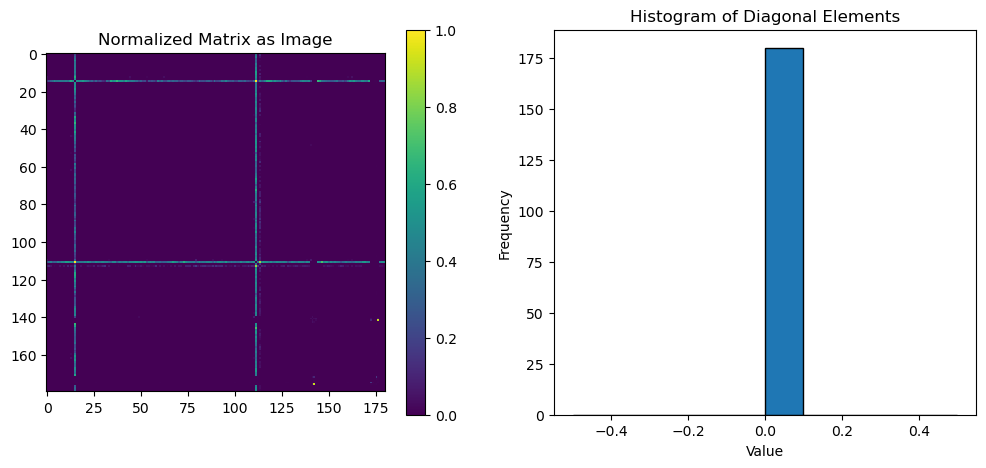

In [110]:
print('determinant of W similarity matrix:', np.linalg.det(W))
block = 180
W_matrix = W[:block,:block]
# print(W_matrix)

# Normalize the W_matrix to the range [0, 1]
normalized_W_matrix = (W_matrix - np.min(W_matrix)) / (np.max(W_matrix) - np.min(W_matrix))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#diagonal elements of the W_matrix
diagonal_elements = np.diag(W_matrix)

# Plot the normalized matrix with a colorbar
cax = axs[0].imshow(normalized_W_matrix, cmap='viridis', interpolation='none')
fig.colorbar(cax, ax=axs[0])
axs[0].set_title('Normalized Matrix as Image')

# Plot the histogram of the diagonal elements
axs[1].hist(diagonal_elements, bins=10, edgecolor='black')
axs[1].set_title('Histogram of Diagonal Elements')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

Debugging the D matrix: There must be a 'zero' in the diagonal of the D matrix.

determinant of D sqrt inv: 5.70658809510068e+216


Text(0, 0.5, 'Frequency')

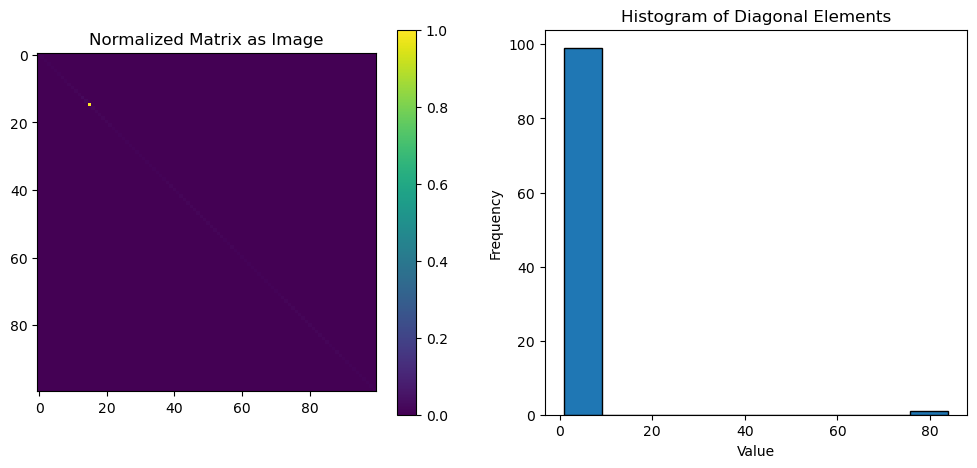

In [73]:
print('determinant of D sqrt inv:', np.linalg.det(D))
block = 100
matrix = D[:block,:block]
# print(matrix)

# Normalize the matrix to the range [0, 1]
normalized_matrix = (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#diagonal elements of the matrix
diagonal_elements = np.diag(matrix)

# Plot the normalized matrix with a colorbar
cax = axs[0].imshow(normalized_matrix, cmap='viridis', interpolation='none')
fig.colorbar(cax, ax=axs[0])
axs[0].set_title('Normalized Matrix as Image')

# Plot the histogram of the diagonal elements
axs[1].hist(diagonal_elements, bins=10, edgecolor='black')
axs[1].set_title('Histogram of Diagonal Elements')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')


determinant of D_sqrt_inv: 4.1861206095476354e-109


Text(0, 0.5, 'Frequency')

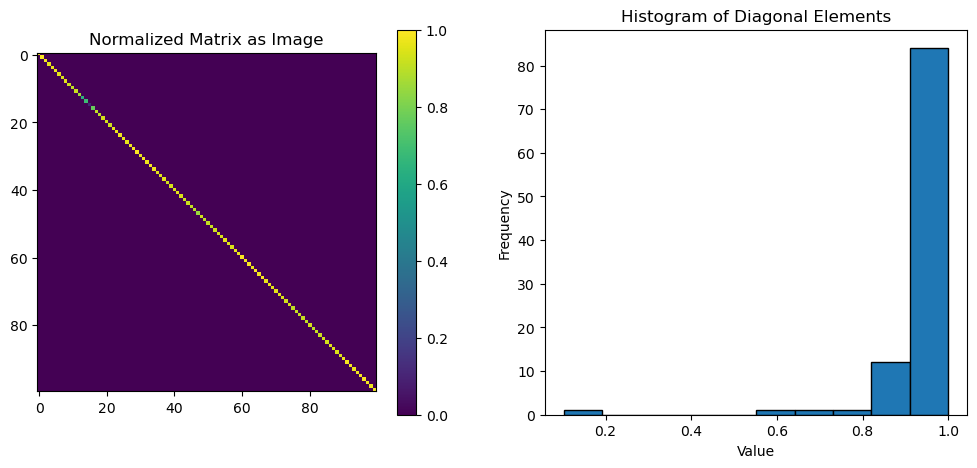

In [74]:
print('determinant of D_sqrt_inv:', np.linalg.det(D_sqrt_inv))
root_inv_matrix = D_sqrt_inv[:block,:block]
# print(root_inv_matrix)

# Normalize the root_inv_matrix to the range [0, 1]
normalized_root_inv_matrix = (root_inv_matrix - np.min(root_inv_matrix)) / (np.max(root_inv_matrix) - np.min(root_inv_matrix))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#diagonal elements of the root_inv_matrix
diagonal_elements = np.diag(normalized_root_inv_matrix)

# Plot the normalized matrix with a colorbar
cax = axs[0].imshow(normalized_root_inv_matrix, cmap='viridis', interpolation='none')
fig.colorbar(cax, ax=axs[0])
axs[0].set_title('Normalized Matrix as Image')

# Plot the histogram of the diagonal elements
axs[1].hist(diagonal_elements, bins=10, edgecolor='black')
axs[1].set_title('Histogram of Diagonal Elements')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')


determinant of L_norm: 5.328238044855537e-19


Text(0, 0.5, 'Frequency')

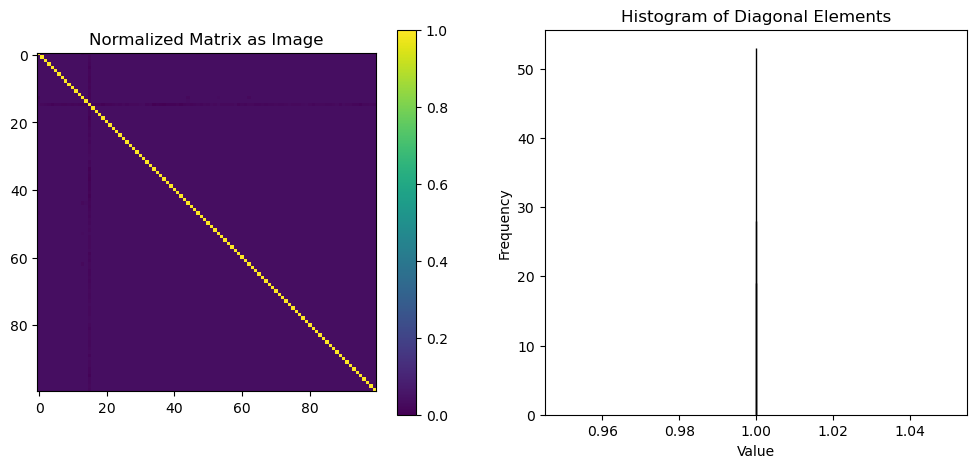

In [75]:
print('determinant of L_norm:', np.linalg.det(L_norm))
L_norm_matrix = L_norm[:block,:block]
# print(L_norm_matrix)

# Normalize the L_norm_matrix to the range [0, 1]
normalized_L_norm_matrix = (L_norm_matrix - np.min(L_norm_matrix)) / (np.max(L_norm_matrix) - np.min(L_norm_matrix))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#diagonal elements of the L_norm_matrix
diagonal_elements = np.diag(normalized_L_norm_matrix)

# Plot the normalized matrix with a colorbar
cax = axs[0].imshow(normalized_L_norm_matrix, cmap='viridis', interpolation='none')
fig.colorbar(cax, ax=axs[0])
axs[0].set_title('Normalized Matrix as Image')

# Plot the histogram of the diagonal elements
axs[1].hist(diagonal_elements, bins=10, edgecolor='black')
axs[1].set_title('Histogram of Diagonal Elements')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

determinant of S: -0.0


Text(0, 0.5, 'Frequency')

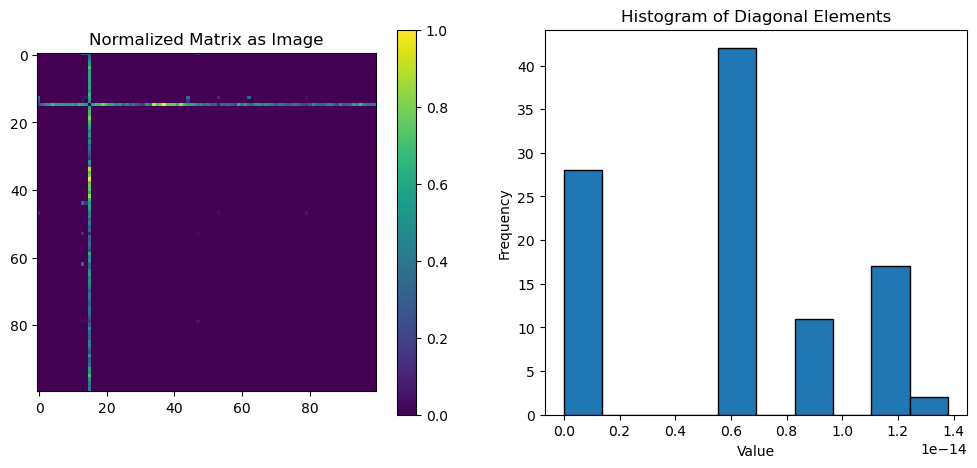

In [76]:
# To get the similarity matrix from the normalized Laplacian, we can use: S = I - L
S = np.eye(L_norm.shape[0]) - L_norm

print('determinant of S:', np.linalg.det(S))
S_matrix = S[:block,:block]
# print(S_matrix)

# Normalize the S_matrix to the range [0, 1]
normalized_S_matrix = (S_matrix - np.min(S_matrix)) / (np.max(S_matrix) - np.min(S_matrix))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#diagonal elements of the S_matrix
diagonal_elements = np.diag(normalized_S_matrix)

# Plot the normalized matrix with a colorbar
cax = axs[0].imshow(normalized_S_matrix, cmap='viridis', interpolation='none')
fig.colorbar(cax, ax=axs[0])
axs[0].set_title('Normalized Matrix as Image')

# Plot the histogram of the diagonal elements
axs[1].hist(diagonal_elements, bins=10, edgecolor='black')
axs[1].set_title('Histogram of Diagonal Elements')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

Using a library to get the normalized Laplacian

In [77]:
from scipy.sparse.csgraph import laplacian
L_norm_v2 = laplacian(W, normed=True)

# print(L_norm_v2)
print(L_norm_v2.shape)
print(np.max(L_norm_v2))
print(np.min(L_norm_v2))

print(np.sum(L_norm_v2 - np.eye(N)))
print(np.max(L_norm_v2 - np.eye(N)))
print(np.min(L_norm_v2 - np.eye(N)))

eigenvalues, _ = np.linalg.eigh(L_norm_v2)
# print(eigenvalues)

sorted_eigenvalues = np.sort(eigenvalues)[::-1]
print(sorted_eigenvalues)

differences = np.diff(sorted_eigenvalues)
i_max = np.argmax(differences)
k = len(sorted_eigenvalues)
print(k)

L_hat_v2 = k - (i_max + 1)
print("number of clusters predicted from L_norm_v2:", L_hat_v2)

# # Step 6: Spectral clustering
spectral_clustering = SpectralClustering(n_clusters=L_hat_v2, affinity='precomputed', random_state=0)
labels = spectral_clustering.fit_predict(W)

(1024, 1024)
1.0
-0.34116205651135056
-534.9995176368927
0.0
-0.34116205651135056
[1.82955432e+00 1.36995600e+00 1.34391587e+00 ... 6.08739791e-01
 1.94304557e-01 2.81022322e-16]
1024
number of clusters predicted from L_norm_v2: 514


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


determinant of L_norm_v2: 1.914815745955061e-18


Text(0, 0.5, 'Frequency')

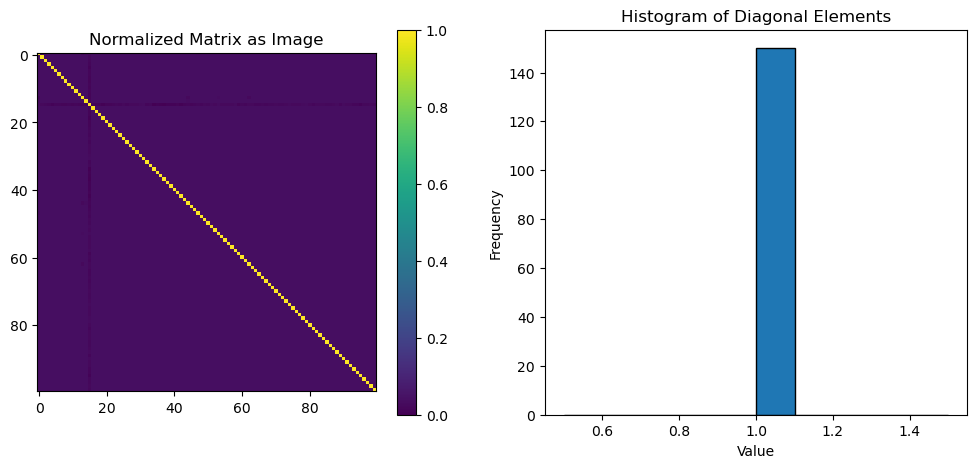

In [87]:
print('determinant of L_norm_v2:', np.linalg.det(L_norm_v2))
L_norm_v2_matrix = L_norm_v2[:block,:block]
# print(L_norm_v2_matrix)

# Normalize the L_norm_v2_matrix to the range [0, 1]
normalized_L_norm_v2_matrix = (L_norm_v2_matrix - np.min(L_norm_v2_matrix)) / (np.max(L_norm_v2_matrix) - np.min(L_norm_v2_matrix))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#diagonal elements of the L_norm_v2_matrix
diagonal_elements = np.diag(normalized_L_norm_v2_matrix)

# Plot the normalized matrix with a colorbar
cax = axs[0].imshow(normalized_L_norm_matrix, cmap='viridis', interpolation='none')
fig.colorbar(cax, ax=axs[0])
axs[0].set_title('Normalized Matrix as Image')

# Plot the histogram of the diagonal elements
axs[1].hist(diagonal_elements, bins=10, edgecolor='black')
axs[1].set_title('Histogram of Diagonal Elements')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

Just check if the number of clusters recommended is a bit too much?

In [88]:
print(labels.shape)
Spectral_cluster_indices = labels

(1024,)


In [89]:
# def getSpectralCluster(Y, num_clusters):
#     """
#     Spectral clustering from scikit-learn
#     """
#     # Spectral clustering with default  params. affinity from rbf kernel
    
#     spectral_clustering = SpectralClustering(n_clusters=num_clusters)
#     labels = spectral_clustering.fit_predict(Y)
   
#     return labels

# Spectral_cluster_indices = getSpectralCluster(im_tiles1d, num_clusters)
# print('SpectralCluster_indices shape:', Spectral_cluster_indices.shape)

select the cluster indices

In [90]:
# cluster_indices = getSpectralCluster(im_tiles1d, num_clusters)

Arranging clusters, means and medoids

In [91]:
def calculate_medoid(cluster):
    """
    cluster: an mxN array of m vectors in a cluster
    """
    # Pairwise distances between points in the cluster
    distances = cdist(cluster, cluster, metric='euclidean')
    total_distances = np.sum(distances, axis=1)
    medoid_index = np.argmin(total_distances)

    # Medoid is the data point with the minimum total distance
    medoid = cluster[medoid_index]

    return medoid

def get_cluster_medoids(data, cluster_indices):
    """
    Inputs:
    data: an mxN array of m data vectors (points)
    cluster_indices: an mx1 array of m cluster indices

    Returns:
    clusters: a dictionary, indexed by cluster number and values are clustered arrays of data
    medoids: a dictionary, indexed by cluster number and values are the medoid data vector
    means: a dictionary, indexed by cluster number and values are means
    
    """
    unique_clusters = np.unique(cluster_indices)

    # Initialise a dictionary to store clusters
    clusters = {cluster: [] for cluster in unique_clusters}

    # Populate clusters dictionary with data points
    for i, cluster_index in enumerate(cluster_indices):
        clusters[cluster_index].append(data[i])

    # Calculate medoid for each cluster
    medoids = {cluster: calculate_medoid(np.array(points)) for cluster, points in clusters.items()}
    means = {cluster: np.mean(np.array(points), axis=0) for cluster, points in clusters.items()}

    return clusters, medoids, means

Centred Clusters

In [92]:
clustered_data, cluster_medoids, cluster_means = get_cluster_medoids(im_tiles1d, Spectral_cluster_indices)
print ('keys of clustered_data:' ,clustered_data.keys())
print ('clustered_data[0] has shape' ,np.array(clustered_data[0]).shape)
print('cluster_medoids[0]  has shape', cluster_medoids[0].shape)
print ('cluster_means[0] has shape' , cluster_means[0].shape)

def get_centered_clusters(clustered_data, cluster_means):
    centered_clusters = {cluster: (np.array(clustered_data[cluster])-cluster_means[cluster]) for cluster in clustered_data.keys()}
    return centered_clusters

centered_clusters = get_centered_clusters(clustered_data, cluster_means)

keys of clustered_data: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 

In [93]:
#check for mean zero--> checked
summa = 0
for i in range(num_clusters):
    summa += centered_clusters[i].sum()
print (summa)

-6.912159733474255e-11


In [94]:
def pca_for_cluster(cluster):
    """ 
    Inputs:
    cluster- mxN centered array of vectors from a single cluster

    Returns:
    cluster_pca
    """
    assert isinstance(cluster, np.ndarray)

    pca = PCA()
    cluster_pca = pca.fit_transform(cluster)
    pca_vectors = pca.components_
    # print('pca vectors shape:', pca_vectors.shape)


    #padding to make the cumsum array have data_dim(8x8=64) length
    data_dim = cluster.shape[-1] 
    padding_size = max(0, data_dim - len(pca.explained_variance_ratio_))
    expl_var_ratio_cumul = np.cumsum(np.pad(pca.explained_variance_ratio_, (0, padding_size), 'constant', constant_values=0))

    return cluster_pca, expl_var_ratio_cumul, pca_vectors

#test pca function
cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(centered_clusters[0])
print(type(cluster_pca), cluster_pca.shape)
print(pca_vectors.shape)


<class 'numpy.ndarray'> (1, 1)
(1, 64)


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


In [95]:
num_clusters = len(centered_clusters)
fig, axs = plt.subplots(nrows= num_clusters, ncols =1, figsize=(8,4* num_clusters))

#clusters_pcavectors and mean- a set basis(psi), one for each cluster
t_exp = 0.9
dynamic_psi = dict()
fixed_psi = dict()
dim_comp = 0.5
fixed_cut = int(dim_comp* np.square(tile_w))

for i, (cluster_key, points) in enumerate(centered_clusters.items()):
    cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(points)

    # find the index that reaches 0.9 cumsum variability
    cutidx = np.argmax(expln_var_cum >= t_exp)
    dynamic_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:cutidx]))
    fixed_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:fixed_cut]))

    # Add the dynamic_basis vectors describing the 0.9 variance
    dynamic_psi[cluster_key] = dynamic_basis

    # Add the fixed_basis vectors which are the 50% of the the basis vectors
    fixed_psi[cluster_key] = fixed_basis

    print('Cluster %d dynamic_basis vectors shape:'%(cluster_key), dynamic_basis.shape)
    print('Cluster compression when pruning %.2f variance is %.4f'%(t_exp, dynamic_basis.shape[0]/points.shape[0]))
    print('--------------------')
                      
    axs[i].plot(range(1, len(expln_var_cum) + 1), expln_var_cum, label='Cluster no.%d with %d vectors'%(cluster_key, points.shape[0]))
    axs[i].set_xlabel('Number of Components')
    axs[i].set_ylabel('Cumultiv Explained Var Ratio')
    axs[i].legend()

# plt.savefig('results/Patching_Image_%d.pdf'%(image_number))
plt.show()

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomp

Cluster 0 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 1 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 0.5000
--------------------
Cluster 2 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 3 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 4 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 5 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 6 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 7 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------


c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomp

Cluster 96 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 97 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 0.5000
--------------------
Cluster 98 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 99 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 100 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 101 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 102 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 103 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
---------

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomp

Cluster 278 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 279 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 280 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 281 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 282 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 283 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 284 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 285 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
-----

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomp

Cluster 388 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 389 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 390 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 391 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 392 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 393 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 394 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
--------------------
Cluster 395 dynamic_basis vectors shape: (1, 64)
Cluster compression when pruning 0.90 variance is 1.0000
-----

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomp

ValueError: Image size of 800x205600 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x205600 with 514 Axes>

Approximate $\hat{x}$ for each data point inside the cluster

In [96]:
# Approximate x_hat = Psi_k alpha; for each tile x_hat
def fit_to_basis(data_vectors, basis_vectors):
    """ 
    basis_vectors : an nxN array with a basis vector(N-dimensional) in each row 
    data_vectors : an mxN array with m examples of (N-dimensional) data.
    """ 
    projection_matrix = basis_vectors.T @ (np.linalg.pinv(basis_vectors @ basis_vectors.T) @ basis_vectors)
    approximations = data_vectors @ projection_matrix
    errors = np.linalg.norm(data_vectors - approximations , axis=1)
    # print(errors.shape)
    return approximations, errors

 cluster 0 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 1 has error after fitting: 
 dynamic basis selection: 81.8532 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 2 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 3 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 4 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 5 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 6 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 7 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 8 has error after fitting: 
 dynamic basis selection: 0.0000 
 fixed top 0.50: 0.0000 
 ------ 
 cluster 9 has error after fitting: 
 dynamic basis se

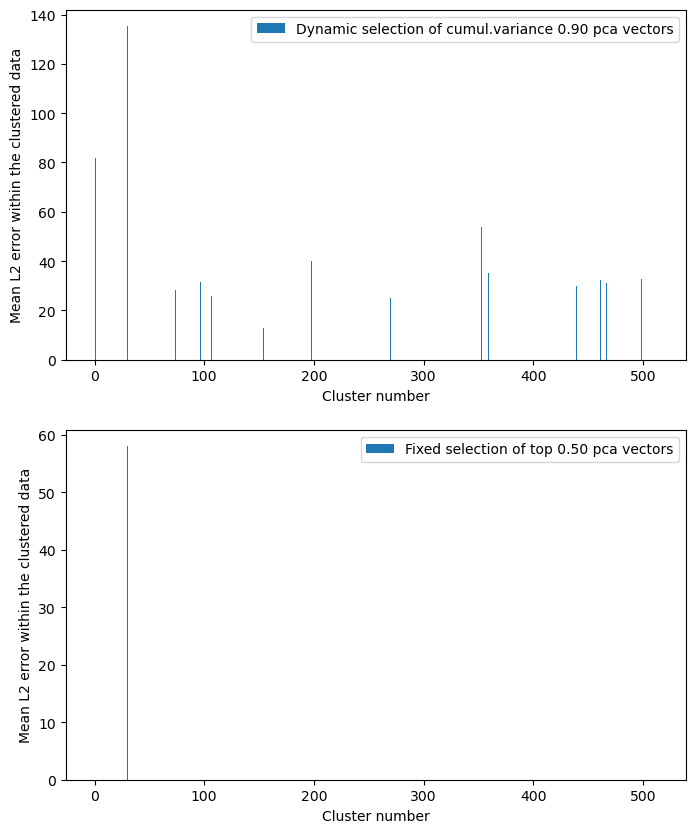

In [97]:
dyn_errors = []
fix_errors = []
for i, (cluster_key, points) in enumerate(clustered_data.items()):
    dyn_approx, dyn_errs = fit_to_basis(clustered_data[cluster_key], dynamic_psi[cluster_key])
    fix_approx, fix_errs = fit_to_basis(clustered_data[cluster_key], fixed_psi[cluster_key])
    dyn_errors.append(np.mean(dyn_errs))
    fix_errors.append(np.mean(fix_errs))
    print(" cluster %d has error after fitting: \n dynamic basis selection: %.4f \n fixed top %.2f: %.4f \n ------ "%(i, np.mean(dyn_errs), dim_comp, np.mean(fix_errs)))

# print(np.array(dyn_errors).shape)

fig, axs = plt.subplots(nrows= 2, ncols =1, figsize=(8,10))
axs[0].bar(np.array(range(num_clusters)), dyn_errors, label='Dynamic selection of cumul.variance %.2f pca vectors'%(t_exp))
axs[0].set_xlabel('Cluster number')
axs[0].set_ylabel('Mean L2 error within the clustered data')
axs[0].legend()

axs[1].bar(range(num_clusters), fix_errors, label='Fixed selection of top %.2f pca vectors'%(dim_comp))
axs[1].set_xlabel('Cluster number')
axs[1].set_ylabel('Mean L2 error within the clustered data')
axs[1].legend()

### Approximate $\hat{x}$ for each $x$ datapoint in the original tiles1d so that I can recreate the image.

In [98]:
print('1D data array shape:',im_tiles1d.shape)
print('cluster indices shape',cluster_indices.shape)


1D data array shape: (1024, 64)
cluster indices shape (1024,)


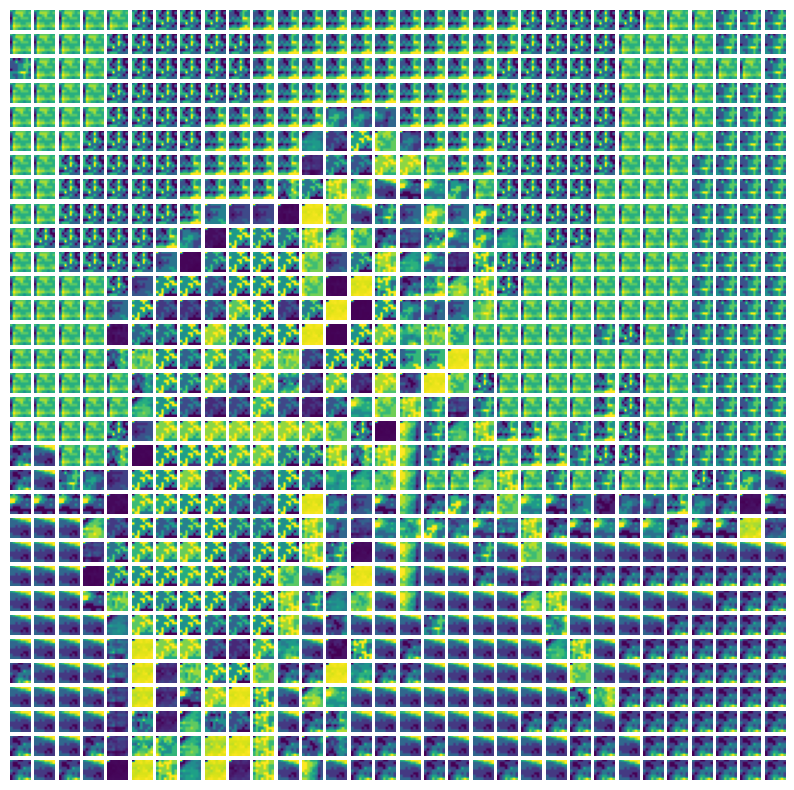

In [99]:
def visualise_approx(im_tiles1d, cluster_indices):
    approx_data1d = np.zeros_like(im_tiles1d)
    error_data = np.zeros_like(im_tiles1d)
    for i in range(len(cluster_indices)):
        fix_approx, fix_errs = fit_to_basis(im_tiles1d[i][np.newaxis,:],fixed_psi[cluster_indices[i]])
        approx_data1d[i] = fix_approx
        error_data[i] = fix_errs

    num_tiles_x = int(np.sqrt(approx_data1d.shape[0]))
    num_tiles_y = int(np.sqrt(approx_data1d.shape[0]))
    tile_width = tile_w
    tile_height = tile_w
    approx_data2d = approx_data1d.reshape(num_tiles_x, num_tiles_x, tile_width, tile_height)
    approx_image = approx_data2d.transpose(0, 2, 1, 3).reshape(num_tiles_y*tile_height, num_tiles_x*tile_width)

    return approx_data2d, approx_image

approx_data2d, approx_image = visualise_approx(im_tiles1d, cluster_indices)
visualize_tiles(approx_data2d)

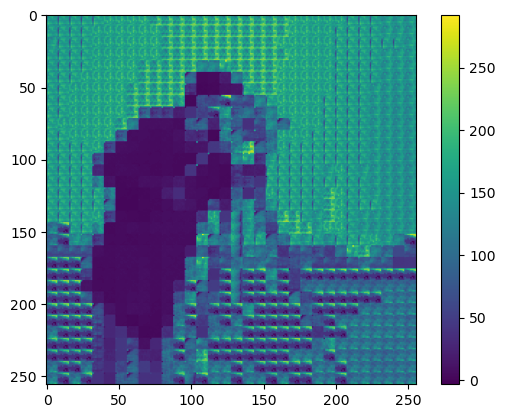

In [100]:
plt.imshow(approx_image)
plt.colorbar()
plt.show()

In [101]:
np.mean(np.square(approx_image - image))

2029.111925009437

### One function to rule them all :p

In [102]:
def clusterdenoising(image, tile_w, num_clusters, t_ratio=0.5):
    """
    Inputs: An image to be denoised, tile width, number of PCA clusters
    Outputs: A cluster approximated image using to t_ratio of PCA vectors
    """
    im_tiles2d, im_tiles1d = return_tiles(image, tile_w)
    im_tiles1d = im_tiles1d.astype(float)

    centroids, _ = kmeans(im_tiles1d, num_clusters)
    # print('data dimensions:', im_tiles1d.shape)
    # print('number of clusters:', num_clusters)
    # print('centroids shape:', centroids.shape)

    #vector quatization
    cluster_indices, _ = vq(im_tiles1d, centroids)
    # print('cluster_indices shape:', cluster_indices.shape)

    clustered_data, cluster_medoids, cluster_means = get_cluster_medoids(im_tiles1d, cluster_indices)
    # print ('keys of clustered_data:' ,clustered_data.keys())
    # print ('clustered_data[0] has shape' ,np.array(clustered_data[0]).shape)
    # print('cluster_medoids[0]  has shape', cluster_medoids[0].shape)
    # print ('cluster_means[0] has shape' , cluster_means[0].shape)

    centered_clusters = get_centered_clusters(clustered_data, cluster_means)

    t_exp = 0.9
    dynamic_psi = dict()
    fixed_psi = dict()
    dim_comp = t_ratio
    fixed_cut = int(dim_comp* np.square(tile_w))

    for i, (cluster_key, points) in enumerate(centered_clusters.items()):
        cluster_pca, expln_var_cum, pca_vectors = pca_for_cluster(points)

        # find the index that reaches 0.9 cumsum variability
        cutidx = np.argmax(expln_var_cum >= t_exp)
        dynamic_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:cutidx]))
        fixed_basis = np.vstack((np.array([cluster_means[cluster_key]]), pca_vectors[:fixed_cut]))

        # Add the dynamic_basis vectors describing the 0.9 variance
        dynamic_psi[cluster_key] = dynamic_basis

        # Add the fixed_basis vectors which are the 50% of the the basis vectors
        fixed_psi[cluster_key] = fixed_basis


    approx_data2d, approx_image = visualise_approx(im_tiles1d, cluster_indices)
    return approx_data2d, approx_image

In [103]:
_ , approx_image = clusterdenoising(image,tile_w=8,num_clusters=20,t_ratio=0.5)

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


In [104]:
def compareNLM(image_number):
    image = cv2.imread(f"Dataset/Image{image_number}.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mindim = np.min(image.shape)
    image = image[:mindim, :mindim]

    # Define Gaussian noise levels
    noise_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

    # Create a plot to display images
    plt.figure(figsize=(15, 8))

    #NLM args
    patch_kw = dict(patch_size=8,      # 8x8 patches
                    patch_distance=6,  # 13x13 search area
                    channel_axis=-1)

    mse_NLM = []
    mse_ours= []

    # Plot noisy images and denoised images
    for i, noise_level in enumerate(noise_levels):
        # Add Gaussian noise to the original image
        noisy_image = np.uint8(np.clip(image + np.random.normal(scale=noise_level, size=image.shape), 0, 255))
        
        # Denoise the noisy image (replace this with your denoising algorithm)
        _,ours_denoised = clusterdenoising(noisy_image,tile_w=8,num_clusters=20,t_ratio=0.5)

        #NLM Slow
        noisy_image_NLM = noisy_image[:,:, np.newaxis]
        sigma_est = np.mean(estimate_sigma(noisy_image_NLM, channel_axis=-1))
        NLM_denoised = (denoise_nl_means(noisy_image_NLM, h=0.7 * sigma_est, fast_mode=False,
                            **patch_kw) * 255).astype(np.uint8)

        mse_NLM.append(np.mean(np.square(NLM_denoised-image)))
        mse_ours.append(np.mean(np.square(ours_denoised-image)))

        # Plot the noisy image
        plt.subplot(3, 10, i + 1)
        plt.imshow(noisy_image)
        plt.title(f'Noisy (σ={noise_level})')
        plt.axis('off')

        # Plot the denoised image
        plt.subplot(3, 10, i + 11)
        plt.imshow(NLM_denoised)
        plt.title(f'AfterNLM (σ={noise_level})')
        plt.axis('off')
        
        # Plot the denoised image
        plt.subplot(3, 10, i + 21)
        plt.imshow(ours_denoised)
        plt.title(f'Ours (σ={noise_level})')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('results/LASSO_Spectral_OursvsNLM_Image_%d_GaussianNoise.png'%(image_number))
    
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, mse_NLM, marker='o', label='NLM')
    plt.plot(noise_levels, mse_ours, marker='o', label='Ours')
    plt.title('MSE Losses for Denoising Methods')
    plt.xlabel('Noise Level')
    plt.ylabel('MSE Loss')
    plt.xticks(noise_levels)
    plt.grid(True)
    plt.legend()
    plt.savefig('results/LASSO_Spectral_OursvsNLM_Image_%d_GaussianNoise_MSE.png'%(image_number))
    

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\sklearn\decomposition\_pca.py:541: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


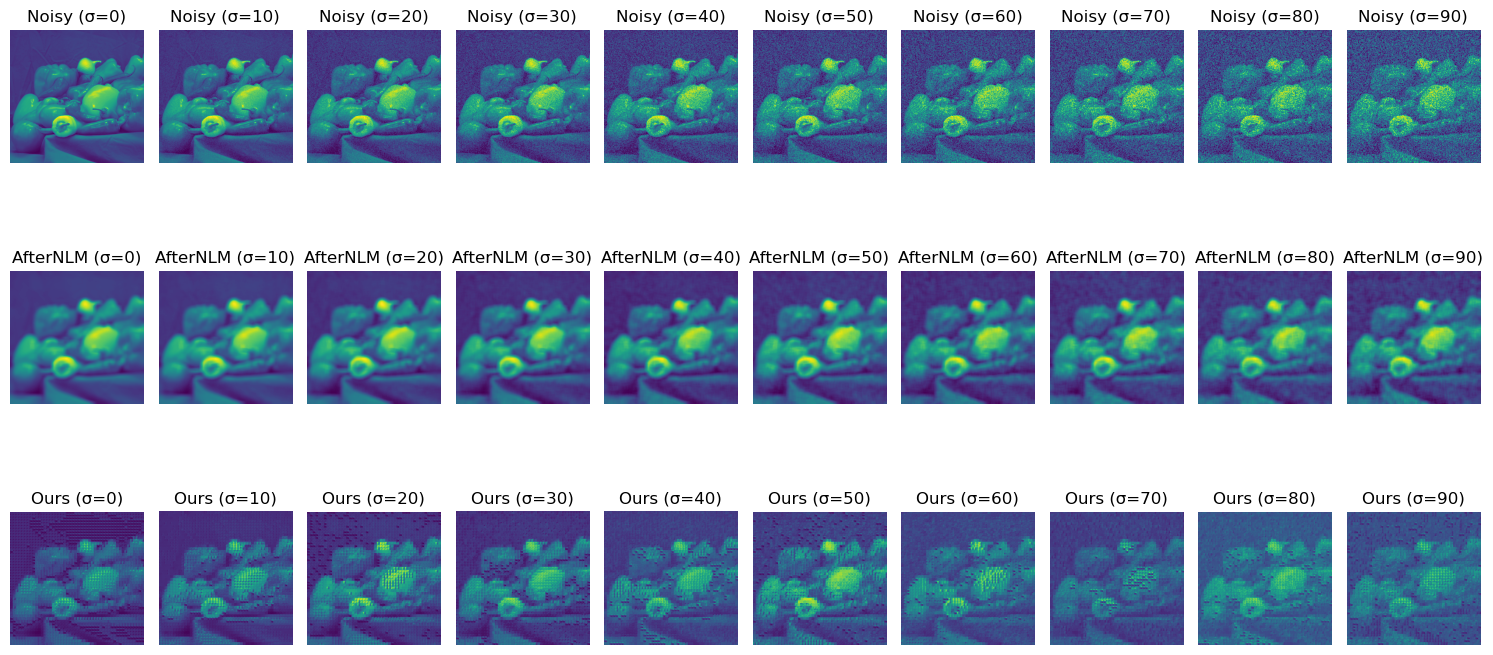

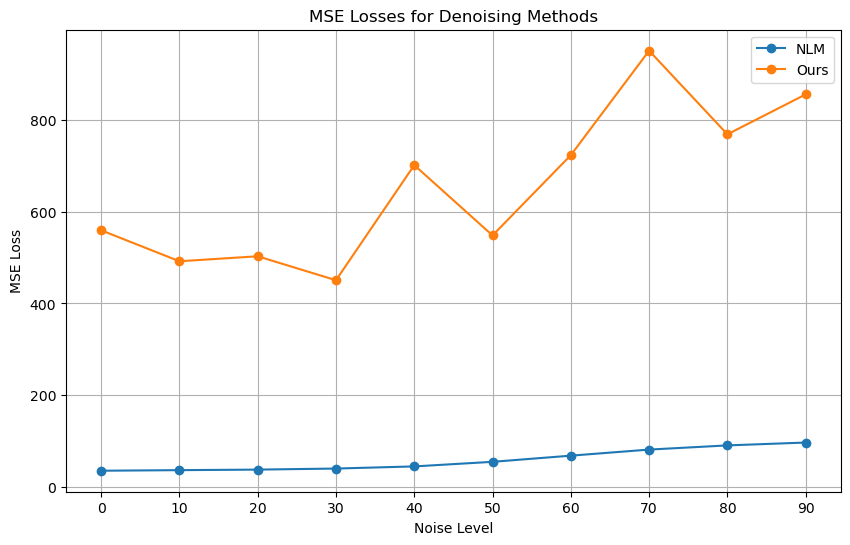

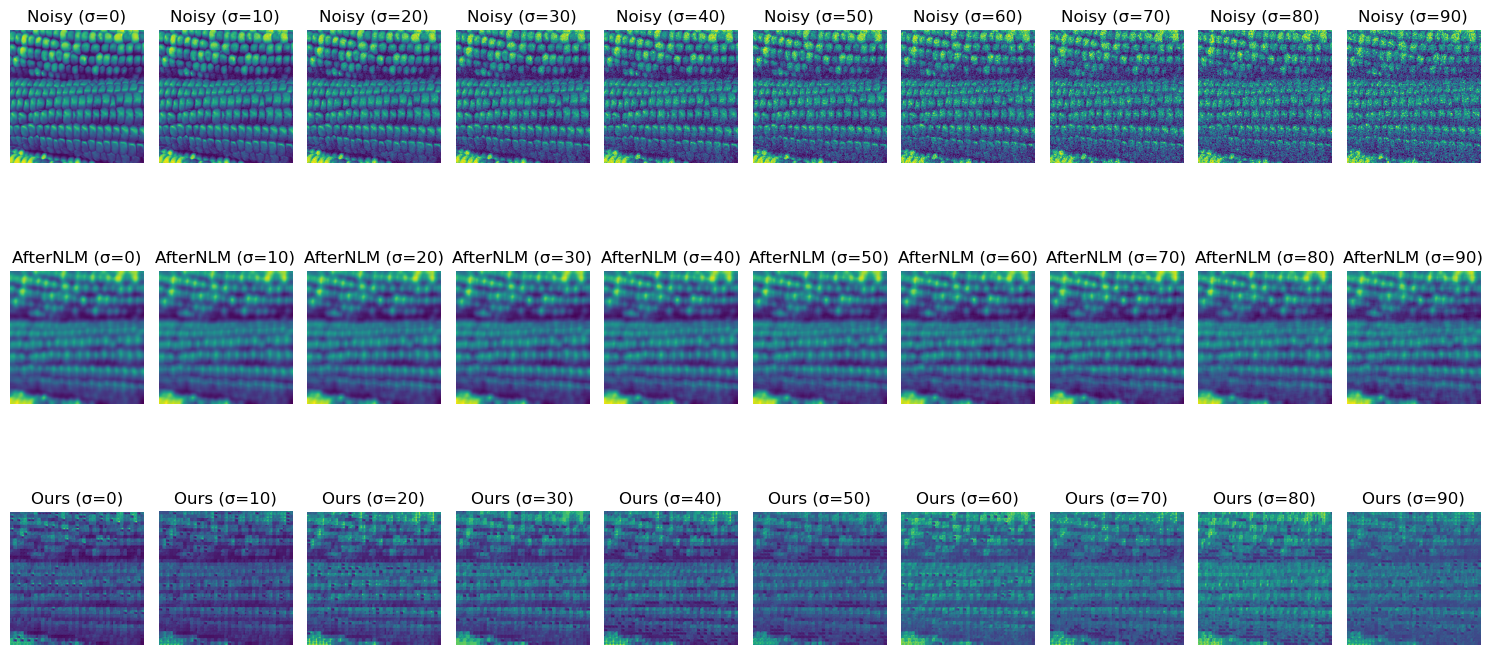

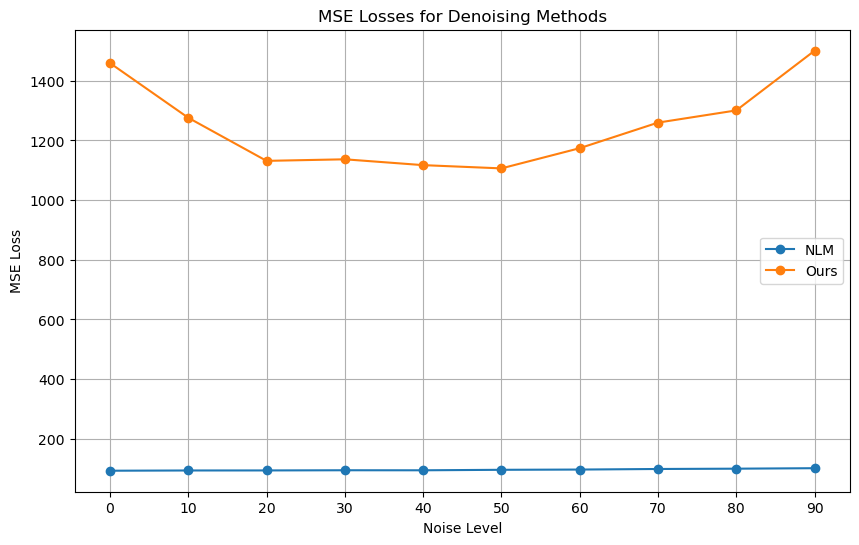

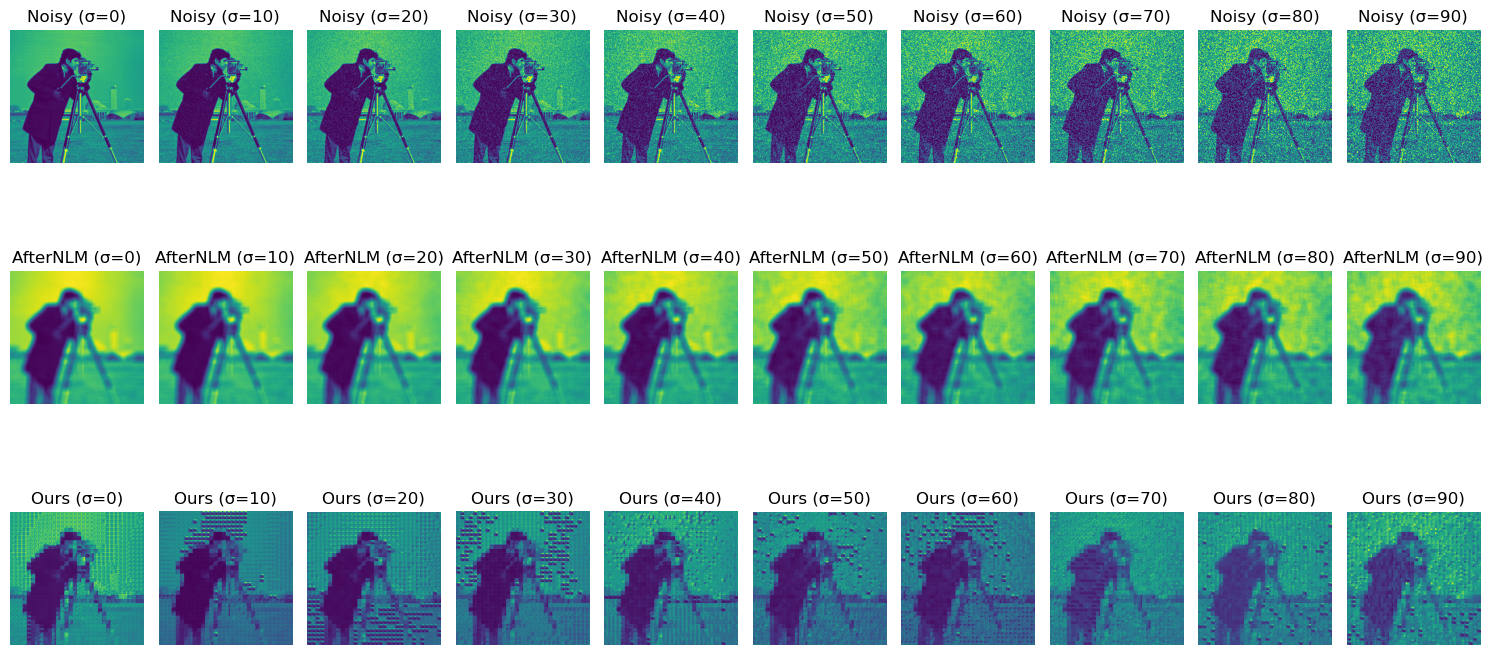

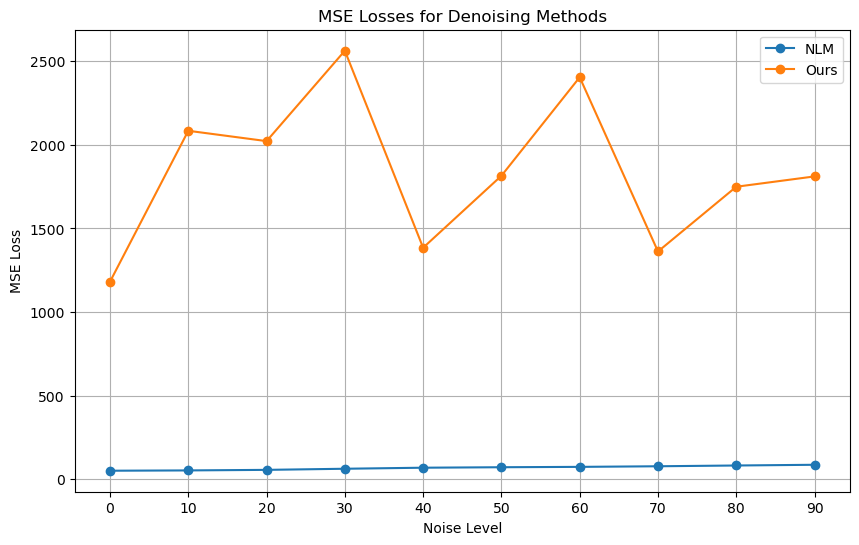

In [105]:
for image_num in range(1,4):
    compareNLM(int(image_num))

In [106]:
#Sanity check
#NLM args
patch_kw = dict(patch_size=8,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                channel_axis=-1)
noisy_image = np.uint8(np.clip(image + np.random.normal(scale=50, size=image.shape), 0, 255))      
noisy_image_NLM = noisy_image[:,:, np.newaxis]
sigma_est = np.mean(estimate_sigma(noisy_image_NLM, channel_axis=-1))
NLM_denoised = denoise = (denoise_nl_means(noisy_image_NLM, h=1.5 * sigma_est, fast_mode=False,
                    **patch_kw) *255).astype(np.uint8)

print(np.mean(np.square(NLM_denoised-image)))

71.35722351074219
